<a href="https://colab.research.google.com/github/Bikash9841/Liver-Segmentation-On-MRI-Images-Using-Monai/blob/main/Liver_Segmentation_On_MRI_Images_using_Monai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install monai
!pip install dicom2nifti

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
from glob import glob
import shutil
import dicom2nifti

## 1. Preparing the Dataset (to be done only once)
- images of the brain of each patient are in form of nifti files.
- each nifti files may have different slices ( which makes up one of many dimension of image)
- we have to convert the nifti files such that all nifti files have same no. of slices.
- for that, first convert nifti files into dicom series via slicer software.
- then group certain no. of dicom files together(lets say 64) and convert it into nifti files.
- now we got nifti files but with same no. of slices each.

## 1.1 Grouping the Dicom Files

In [ ]:
# lets make the slice of each niffty file equal

# group images and labels one by one by replacing the corresponding path locations

in_path='/home/bikasherl/Desktop/brain/dicomfile/test_label'
out_path='/home/bikasherl/Desktop/brain/dicomgroups/test_labels'


for patient in sorted(glob(in_path+'/*')):
    patient_name=os.path.basename(os.path.normpath(patient))
    num_folders=int(len(glob(patient+'/*'))/64)
    print(num_folders)

    for i in range(num_folders):
        output_path_name=os.path.join(out_path,patient_name+'_'+str(i))
        os.mkdir(output_path_name)
        for j,file in enumerate(sorted(glob(patient+'/*'))):
            if j==64:
                break
            shutil.move(file,output_path_name)

## 1.2 Convert Each Groups of Dicom Files into Nifti Files

In [ ]:
# Convert the dicom files into nifti files.


in_path_images='/home/bikasherl/Desktop/brain/dicomgroups/test_images/*'
in_path_labels='/home/bikasherl/Desktop/brain/dicomgroups/test_labels/*'

out_path_images='/home/bikasherl/Desktop/brain/Nifti_files/test_images'
out_path_labels='/home/bikasherl/Desktop/brain/Nifti_files/test_labels'

list_images=glob(in_path_images)
list_labels=glob(in_path_labels)


for patient in list_labels:
    patient_name=os.path.basename(os.path.normpath(patient))
    dicom2nifti.dicom_series_to_nifti(patient,os.path.join(out_path_labels,patient_name+'.nii.gz'))


## 2. Preprocessing on the dataset
- Transformations on images
- Dataloaders


In [5]:
from monai.utils import first
import matplotlib.pyplot as plt
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism
from monai.transforms import (
    Compose,
    EnsureChannelFirstD,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,

)

In [6]:
def prepare(in_dir, pixdim=(1.5, 1.5, 1.0), a_min=-200, a_max=200, spatial_size=[128, 128, 64], cache=True):

    set_determinism(seed=0)

    path_train_images=sorted(glob(os.path.join(dataset,'train_images','*.nii.gz')))
    path_train_labels=sorted(glob(os.path.join(dataset,'train_labels','*.nii.gz')))
    path_test_images=sorted(glob(os.path.join(dataset,'test_images','*.nii.gz')))
    path_test_labels=sorted(glob(os.path.join(dataset,'test_labels','*.nii.gz')))

    train_files=[{"imag":image,"lab":label} for image,label in zip(path_train_images,path_train_labels)]
    test_files=[{"imag":image,"lab":label} for image,label in zip(path_test_images,path_test_labels)]

    train_transforms = Compose(
        [
            LoadImaged(keys=["imag", "lab"]),
            EnsureChannelFirstD(keys=["imag", "lab"]),
            Spacingd(keys=["imag", "lab"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["imag", "lab"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["imag"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=["imag", "lab"], source_key="imag"),
            Resized(keys=["imag", "lab"], spatial_size=spatial_size),
            ToTensord(keys=["imag", "lab"]),

        ]
    )

    test_transforms = Compose(
        [
            LoadImaged(keys=["imag", "lab"]),
            EnsureChannelFirstD(keys=["imag", "lab"]),
            Spacingd(keys=["imag", "lab"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["imag", "lab"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["imag"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=["imag", "lab"], source_key="imag"),
            Resized(keys=["imag", "lab"], spatial_size=spatial_size),
            ToTensord(keys=["imag", "lab"]),

        ]
    )

    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = Dataset(data=test_files, transform=test_transforms)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

## 3. UTILITIES


In [7]:
from monai.utils import first
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
from monai.losses import DiceLoss
from tqdm import tqdm

In [8]:
def dice_metric(predicted, target):
    '''
    In this function we take `predicted` and `target` (label) to calculate the dice coeficient then we use it
    to calculate a metric value for the training and the validation.
    '''
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value


def calculate_weights(val1, val2):
    '''
    In this function we take the number of the background and the forgroud pixels to return the `weights`
    for the cross entropy loss values.
    '''
    count = np.array([val1, val2])
    summ = count.sum()
    weights = count/summ
    weights = 1/weights
    summ = weights.sum()
    weights = weights/summ
    return torch.tensor(weights, dtype=torch.float32)



def train(model, data_in, loss, optim, max_epochs, model_dir, test_interval=1, device=device):
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_test = []
    save_metric_train = []
    save_metric_test = []
    train_loader, test_loader = data_in

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        train_step = 0
        epoch_metric_train = 0
        for batch_data in train_loader:

            train_step += 1

            volume = batch_data["imag"]
            label = batch_data["lab"]
            label = label != 0
            volume, label = (volume.to(device), label.to(device))

            optim.zero_grad()
            outputs = model(volume)

            train_loss = loss(outputs, label)

            train_loss.backward()
            optim.step()

            train_epoch_loss += train_loss.item()
            print(
                f"{train_step}/{len(train_loader) // train_loader.batch_size}, "
                f"Train_loss: {train_loss.item():.4f}")

            train_metric = dice_metric(outputs, label)
            epoch_metric_train += train_metric
            print(f'Train_dice: {train_metric:.4f}')

        print('-'*20)

        train_epoch_loss /= train_step
        print(f'Epoch_loss: {train_epoch_loss:.4f}')
        save_loss_train.append(train_epoch_loss)
        np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)

        epoch_metric_train /= train_step
        print(f'Epoch_metric: {epoch_metric_train:.4f}')

        save_metric_train.append(epoch_metric_train)
        np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

        if (epoch + 1) % test_interval == 0:

            model.eval()
            with torch.no_grad():
                test_epoch_loss = 0
                test_metric = 0
                epoch_metric_test = 0
                test_step = 0

                for test_data in test_loader:

                    test_step += 1

                    test_volume = test_data["imag"]
                    test_label = test_data["lab"]
                    test_label = test_label != 0
                    test_volume, test_label = (test_volume.to(device), test_label.to(device),)

                    test_outputs = model(test_volume)

                    test_loss = loss(test_outputs, test_label)
                    test_epoch_loss += test_loss.item()
                    test_metric = dice_metric(test_outputs, test_label)
                    epoch_metric_test += test_metric


                test_epoch_loss /= test_step
                print(f'test_loss_epoch: {test_epoch_loss:.4f}')
                save_loss_test.append(test_epoch_loss)
                np.save(os.path.join(model_dir, 'loss_test.npy'), save_loss_test)

                epoch_metric_test /= test_step
                print(f'test_dice_epoch: {epoch_metric_test:.4f}')
                save_metric_test.append(epoch_metric_test)
                np.save(os.path.join(model_dir, 'metric_test.npy'), save_metric_test)

                if epoch_metric_test > best_metric:
                    best_metric = epoch_metric_test
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(
                        model_dir, "best_metric_model.pth"))

                print(
                    f"current epoch: {epoch + 1} current mean dice: {test_metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )


    print(
        f"train completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}")



def show_patient(data, SLICE_NUMBER=1, train=True, test=False):
    """
    This function is to show one patient from your dataset.

    `data`: train/test dataloader.
    `SLICE_NUMBER`: this parameter will take the slice number of the nifti file that you want to display
    `train`: boolean to choose train data
    `test`: boolean to choose test data
    """

    check_patient_train, check_patient_test = data

    view_train_patient = first(check_patient_train)
    view_test_patient = first(check_patient_test)


    if train:

        plt.figure("Visualization Train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"image {SLICE_NUMBER}")
        plt.imshow(view_train_patient['imag'][0,0,:, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"label {SLICE_NUMBER}")
        plt.imshow(view_train_patient["lab"][0, 0, :, :, SLICE_NUMBER])
        plt.show()

    if test:
        plt.figure("Visualization Test", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"image {SLICE_NUMBER}")
        plt.imshow(view_test_patient["image"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"label {SLICE_NUMBER}")
        plt.imshow(view_test_patient["label"][0, 0, :, :, SLICE_NUMBER])
        plt.show()



def calculate_pixels(data):
    val = np.zeros((1, 2))

    for batch in tqdm(data):
        batch_label = batch["seg"] != 0
        _, count = np.unique(batch_label, return_counts=True)

        if len(count) == 1:
            count = np.append(count, 0)
        val += count

    print('The last values:', val)
    return val

## 4. Training the model

In [13]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss

import torch
# from preporcess import prepare
# from utilities import train


dataset='/content/drive/MyDrive/Monai_Data/Liver/Nifti_files'
model_save = '/content/drive/MyDrive/Monai_Data/Liver'


# dataset='/content/drive/MyDrive/Liver/Nifti_files'
# model_save = '/content/drive/MyDrive/Liver'

data_in = prepare(dataset, cache=True)

Loading dataset: 100%|██████████| 14/14 [00:51<00:00,  3.71s/it]


In [11]:
# show_patient(data_in,50)

# device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)


#loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, squared_pred=True, ce_weight=calculate_weights(1792651250,2510860).to(device))
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)


# train(model, data_in, loss_function, optimizer, 100, model_save)

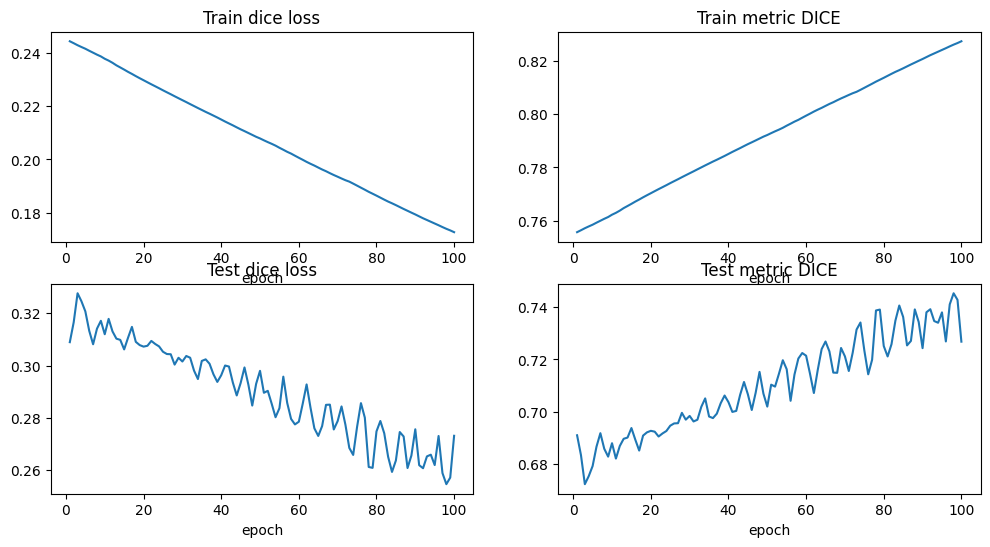

In [17]:
train_loss = np.load(os.path.join(model_save, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_save, 'metric_train.npy'))
test_loss = np.load(os.path.join(model_save, 'loss_test.npy'))
test_metric = np.load(os.path.join(model_save, 'metric_test.npy'))


plt.figure("Results 25 june", (12, 6))
plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Train metric DICE")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title("Test dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("Test metric DICE")
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

## Load the model

In [15]:
model.load_state_dict(torch.load(
    os.path.join(model_save, "best_metric_model.pth"),map_location=device))
# train(model, data_in, loss_function, optimizer, 100, model_save)


<All keys matched successfully>

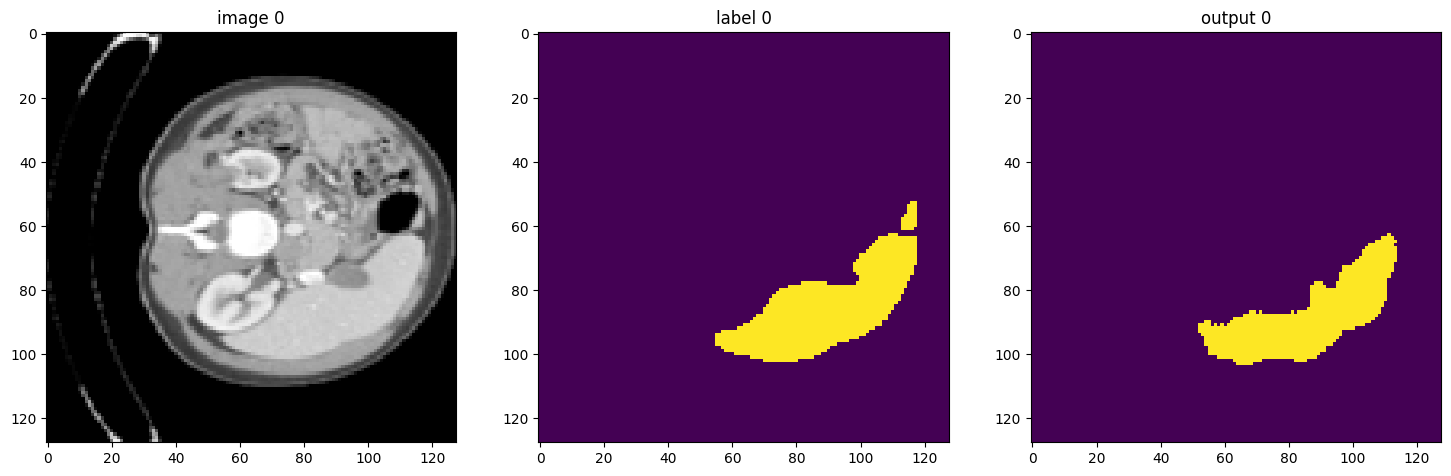

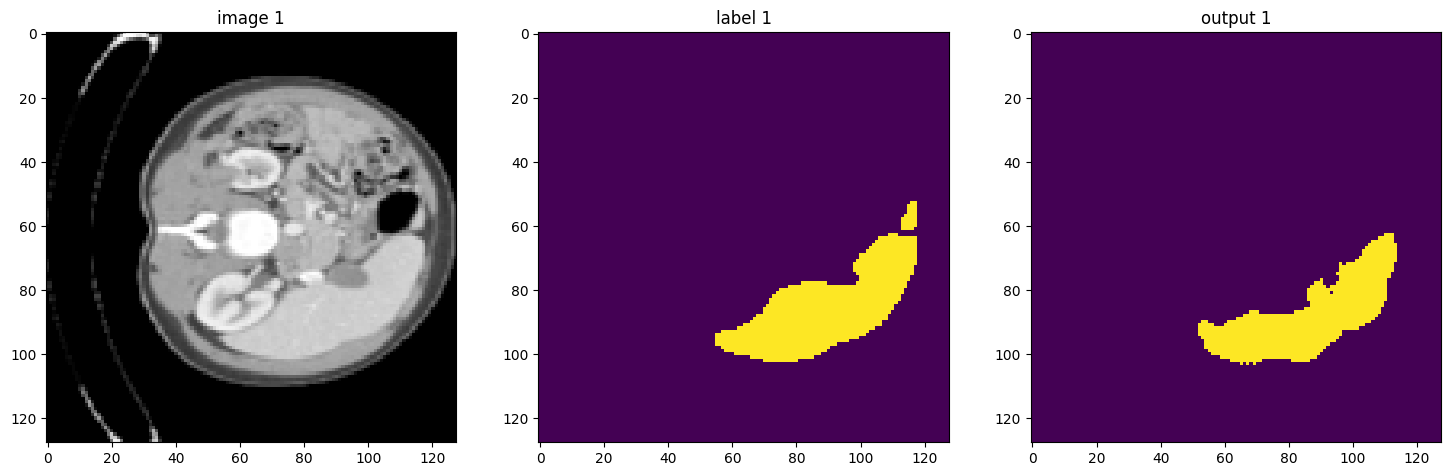

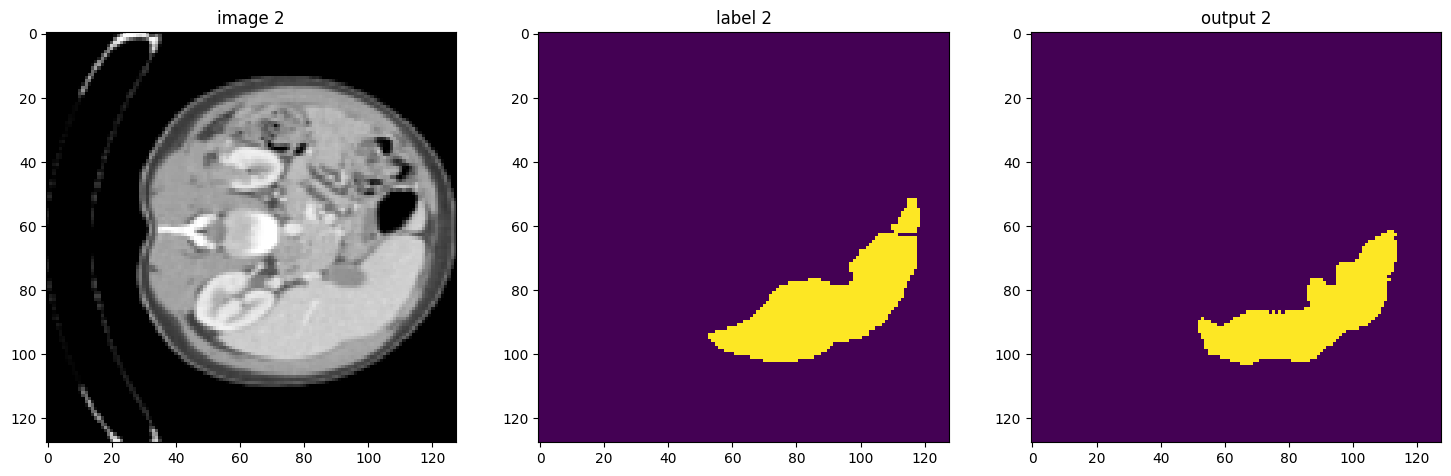

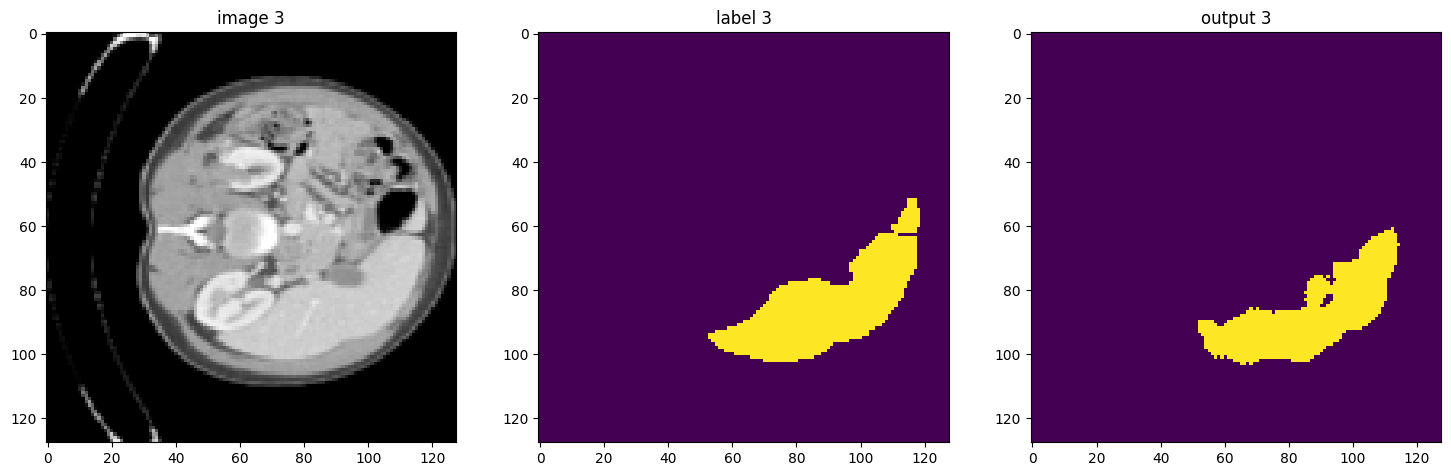

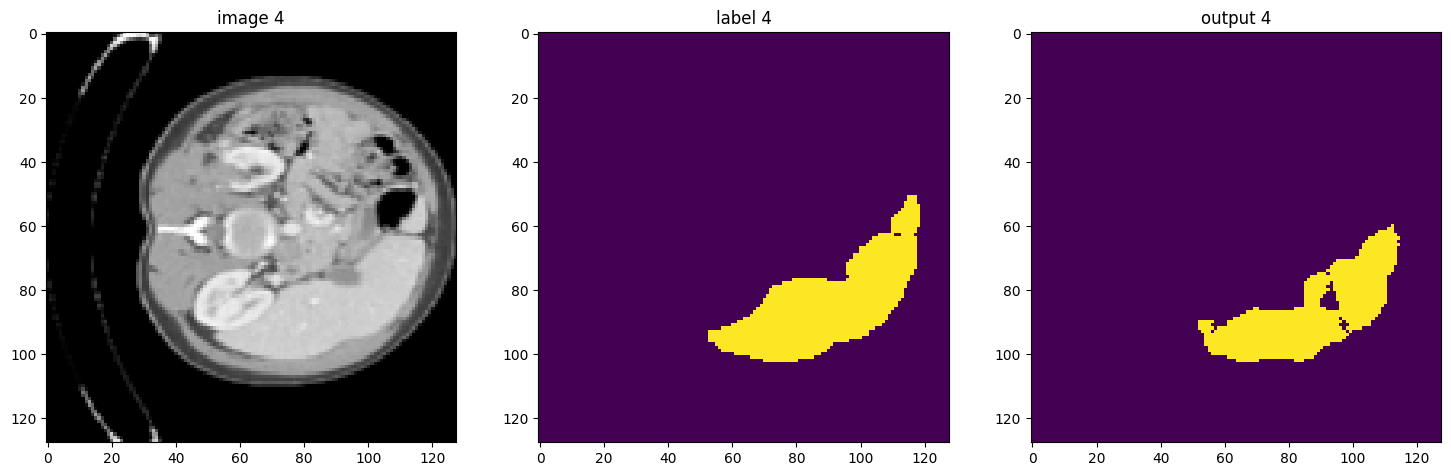

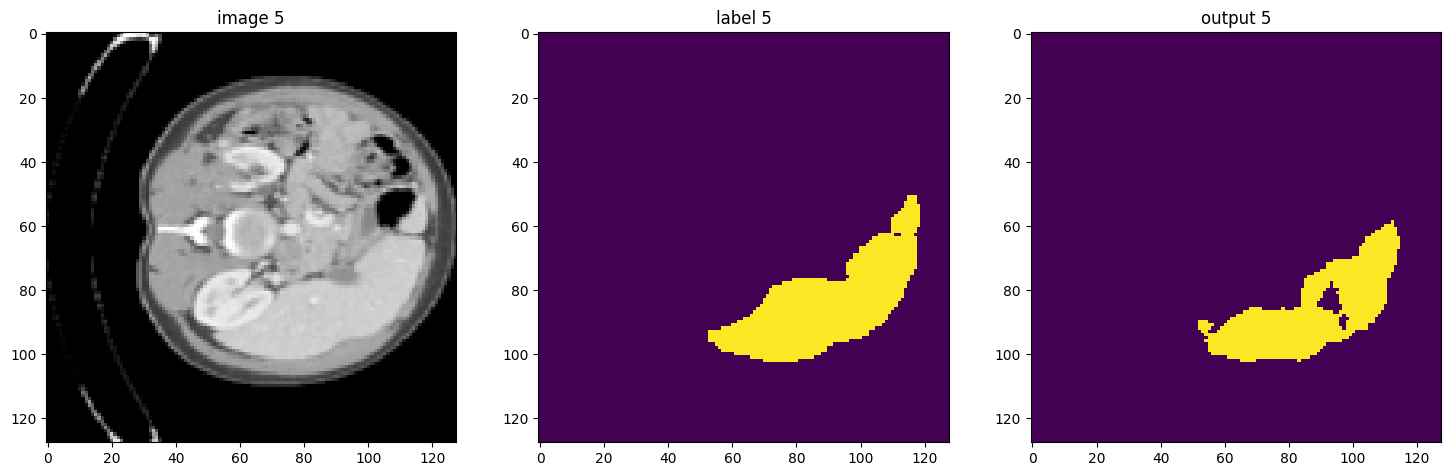

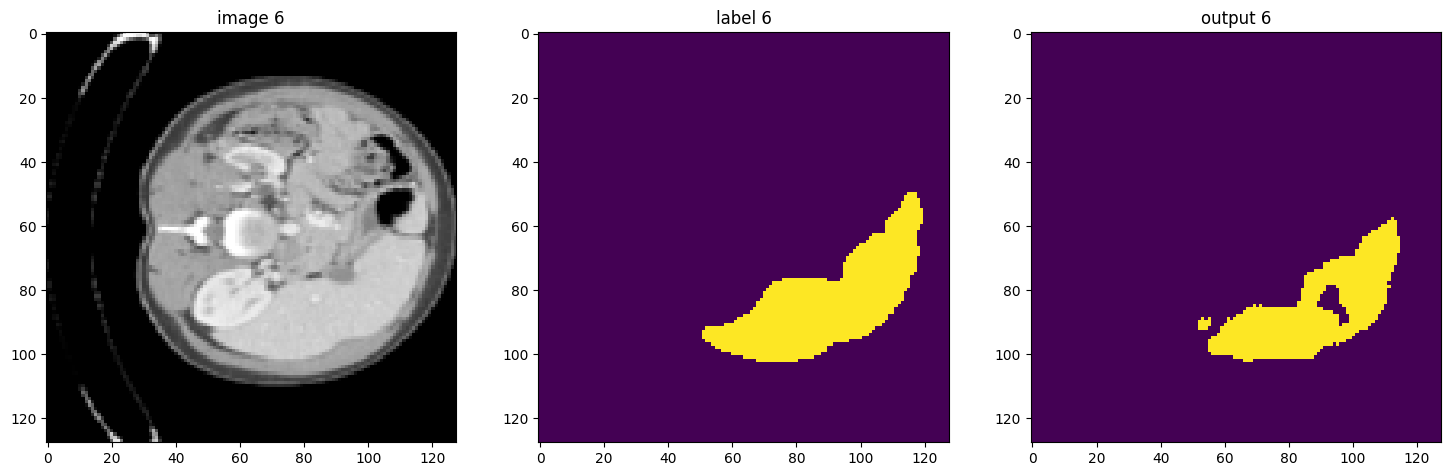

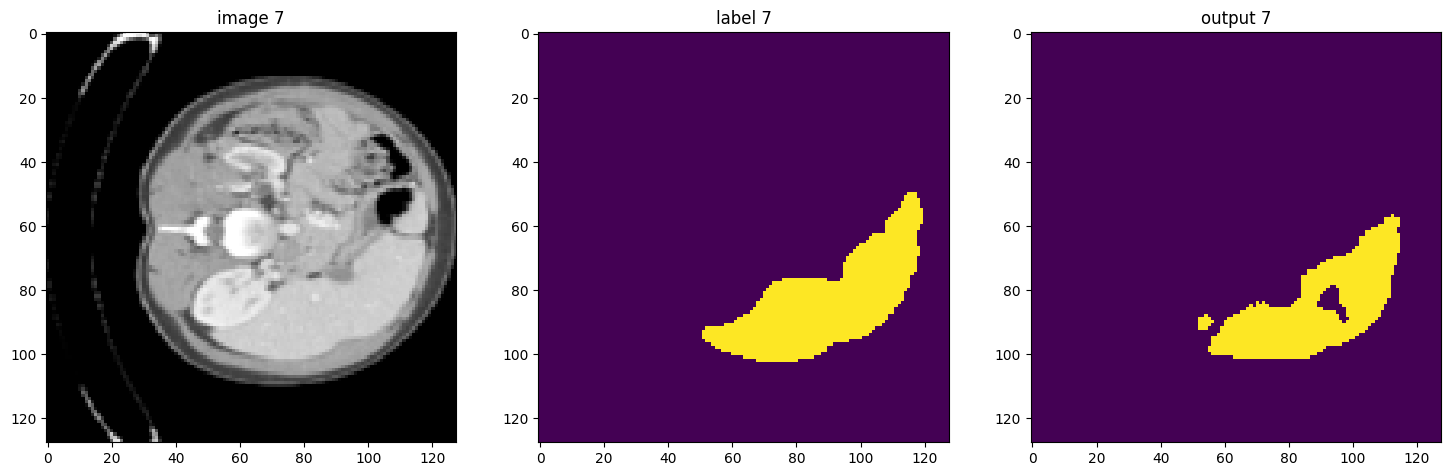

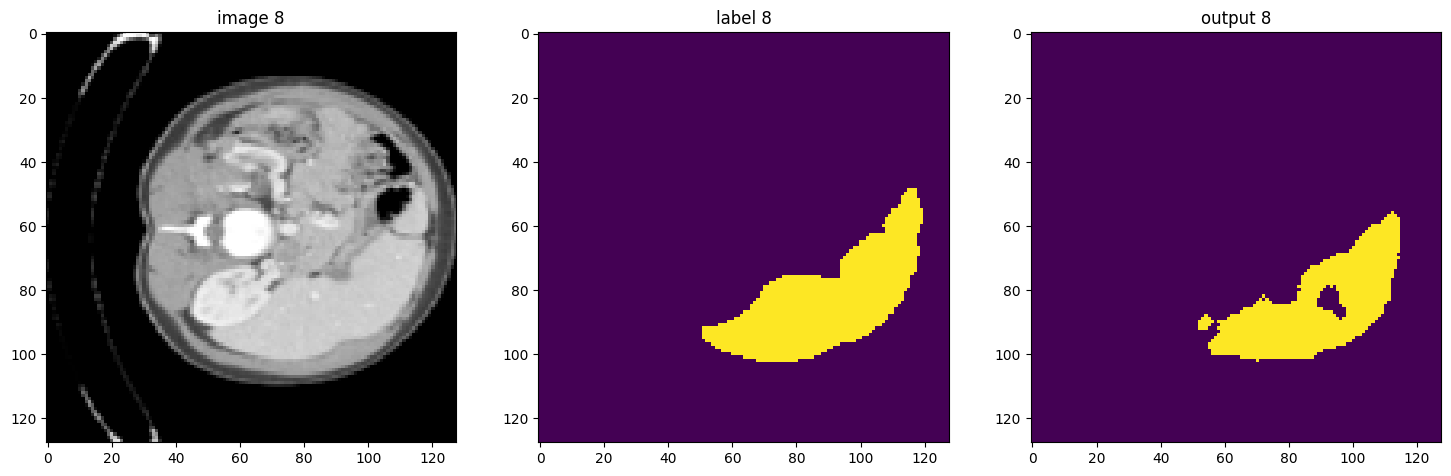

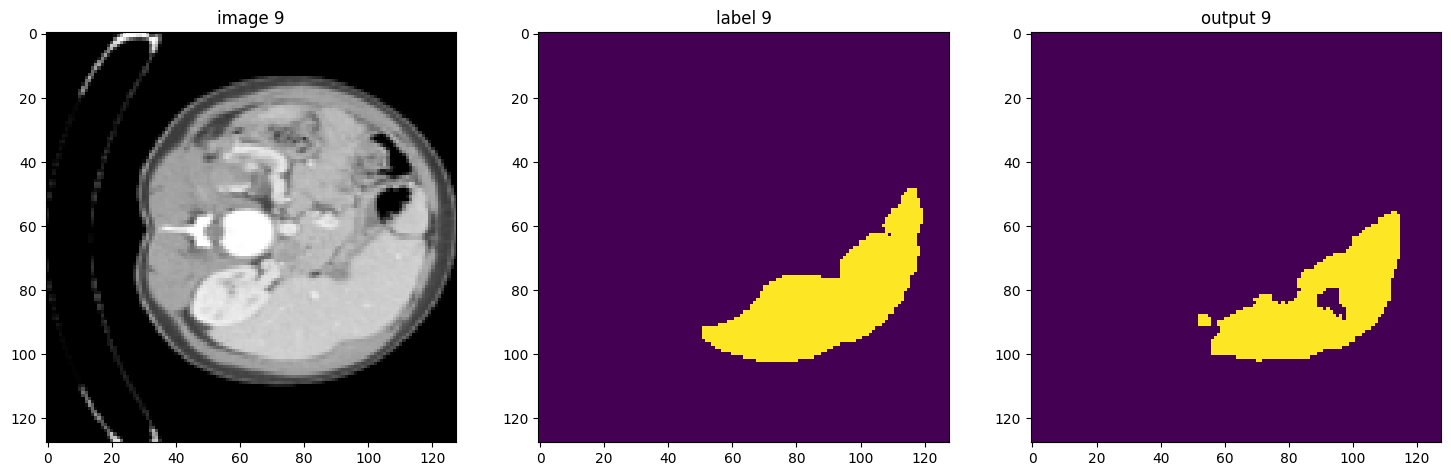

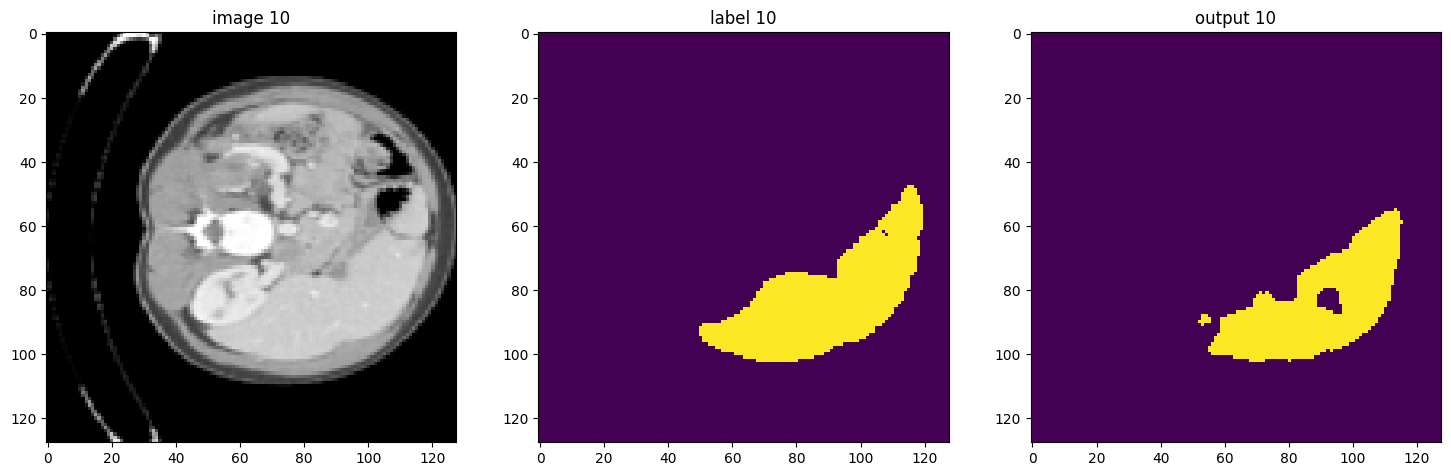

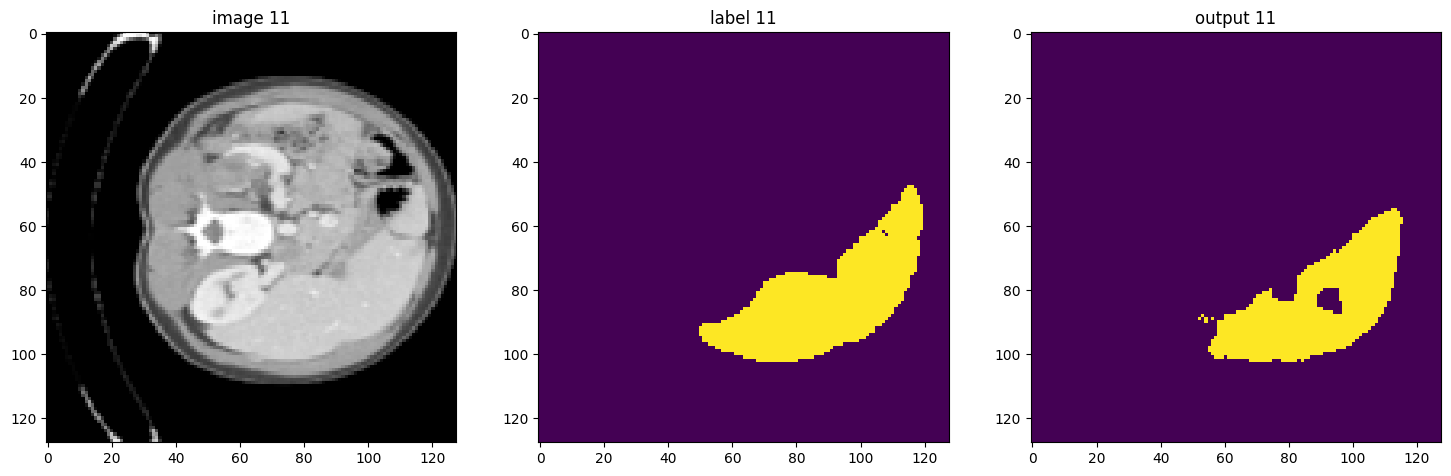

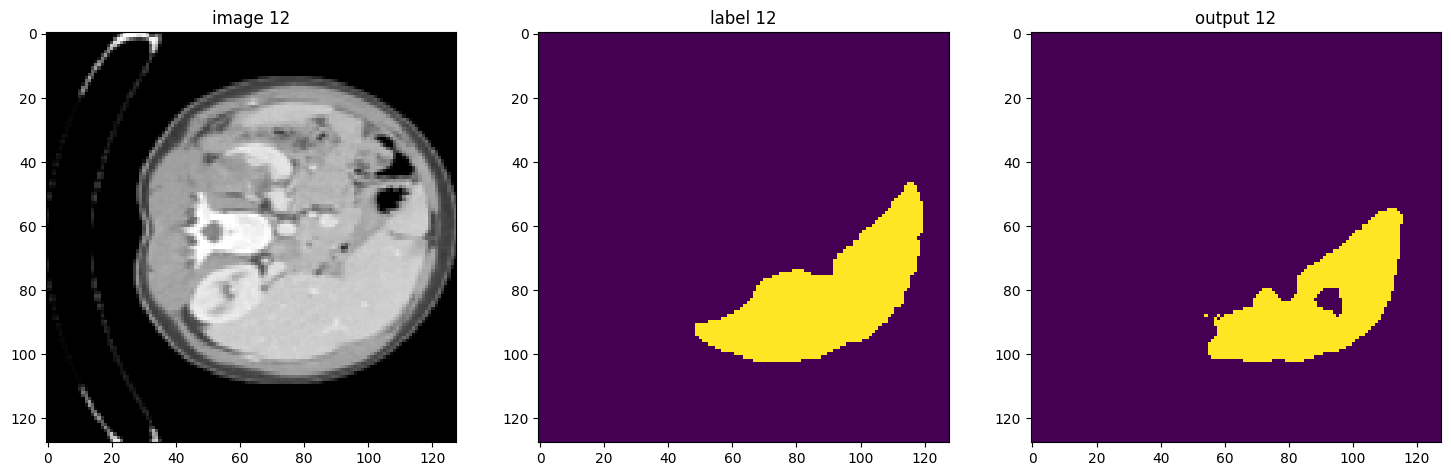

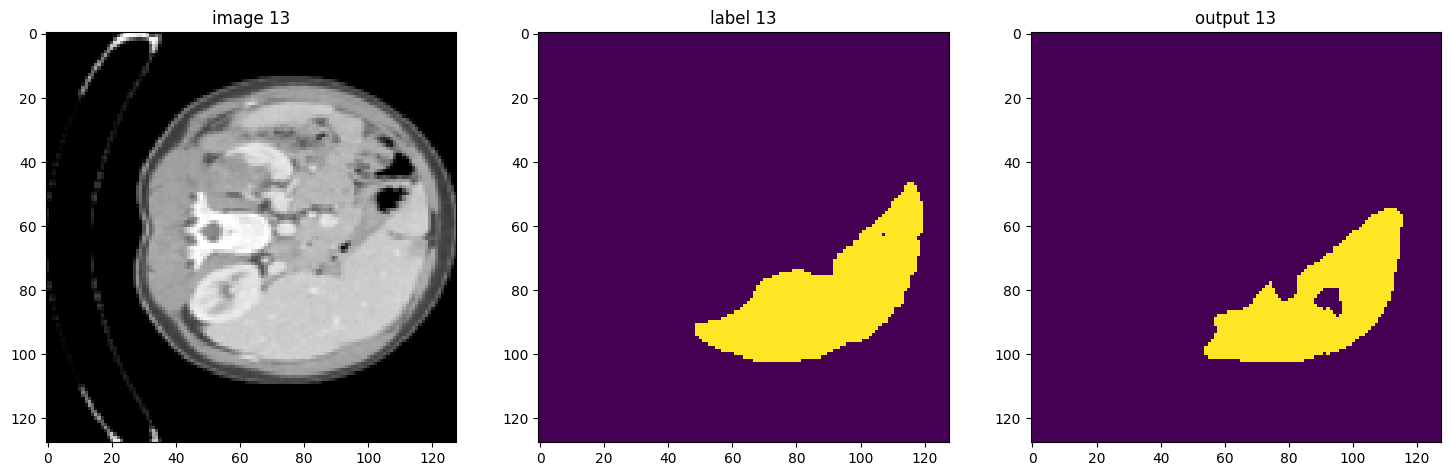

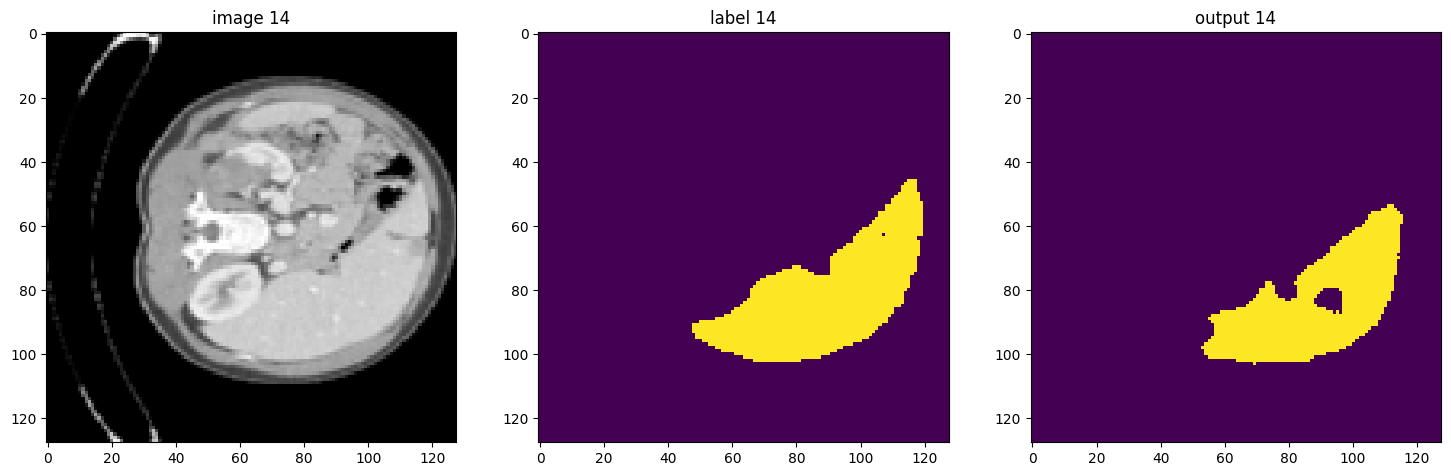

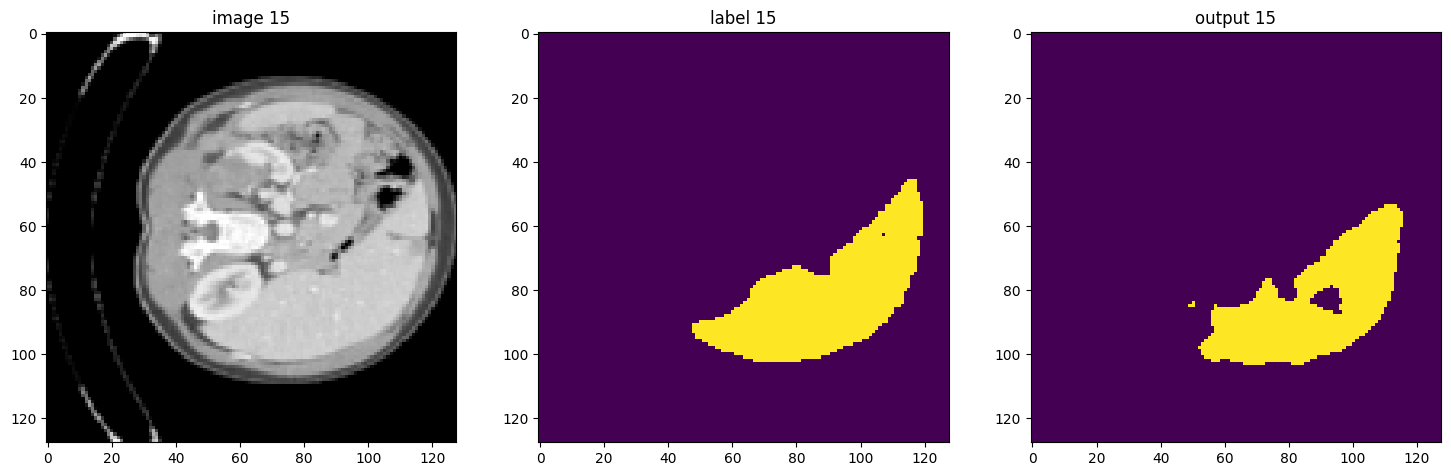

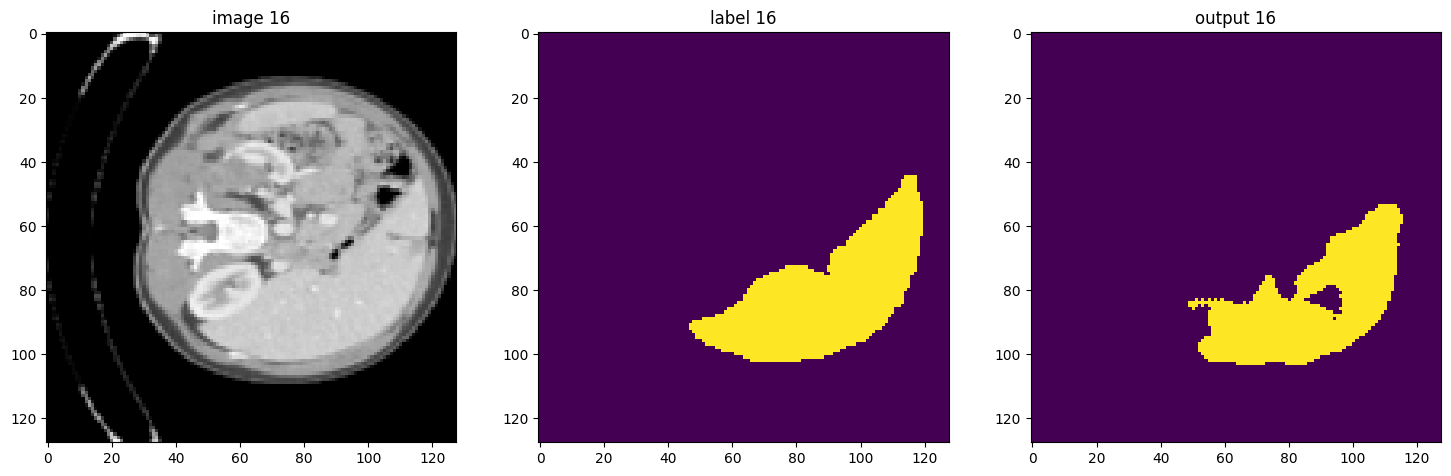

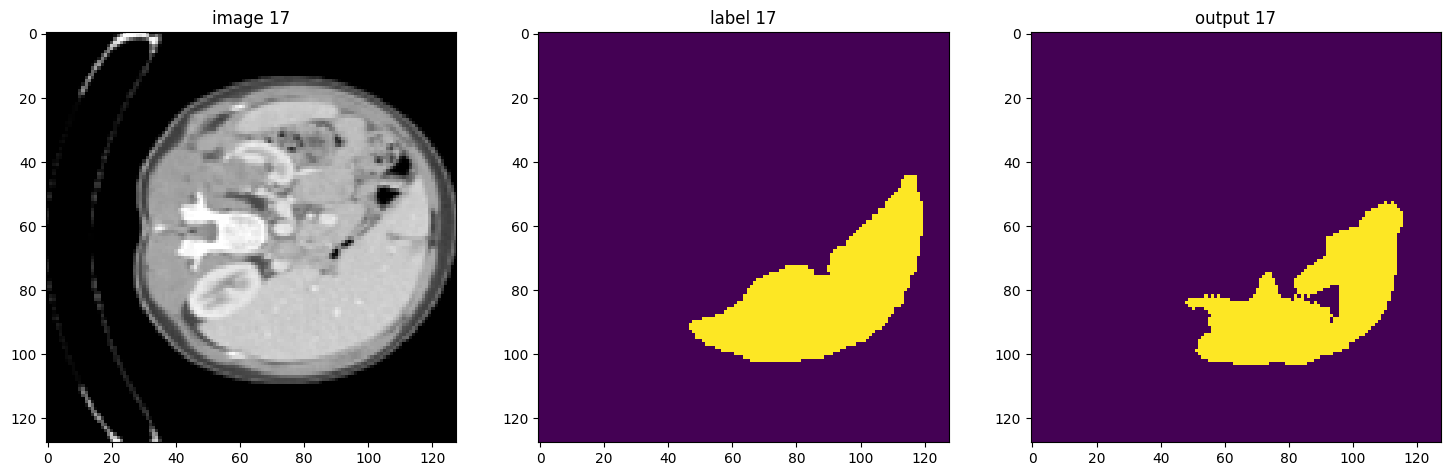

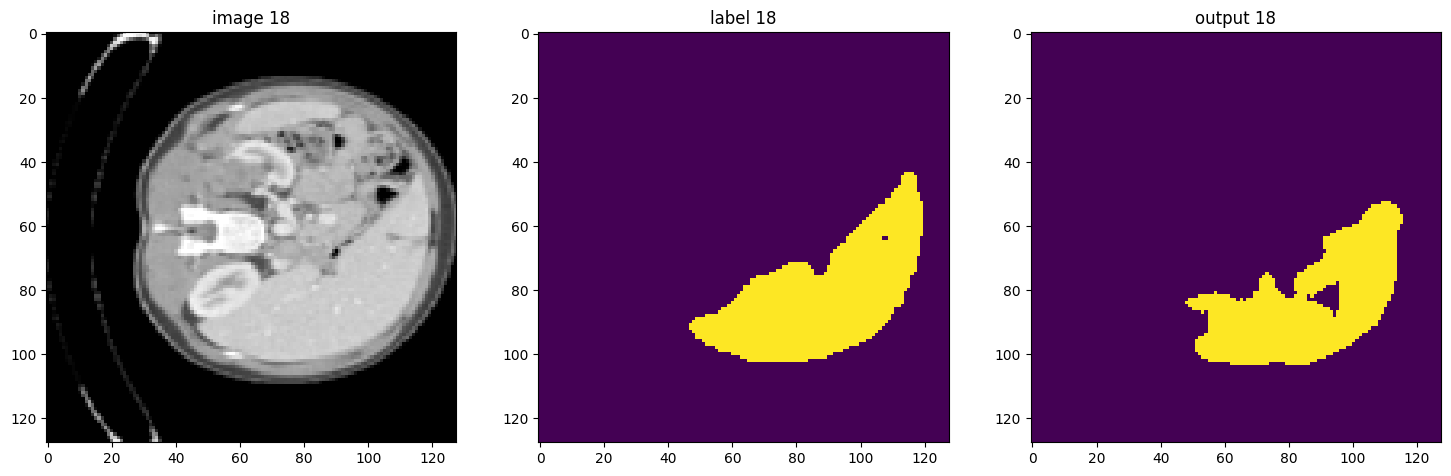

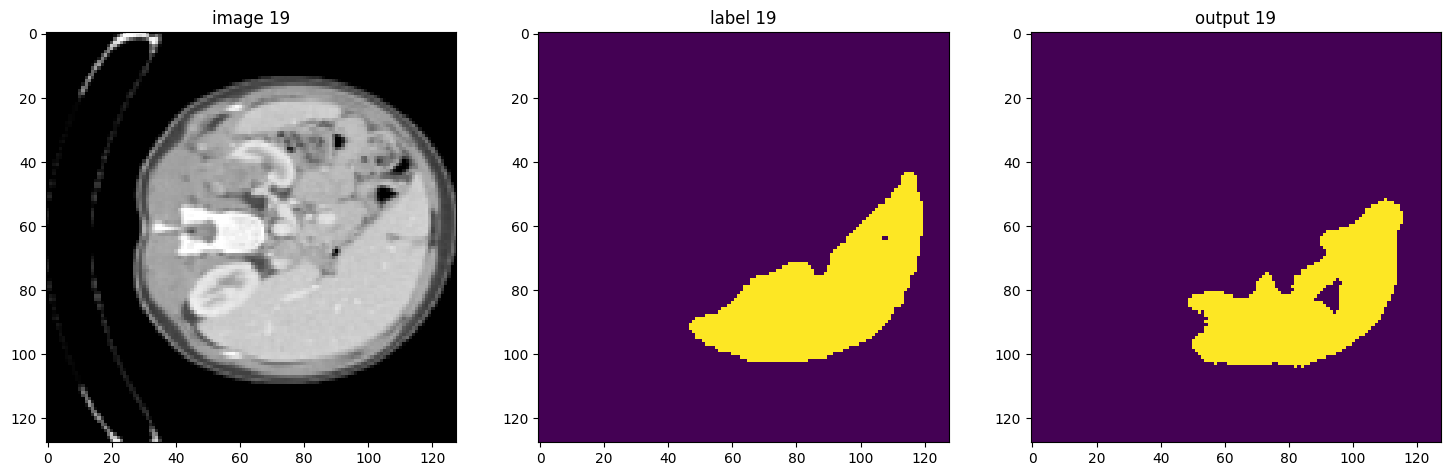

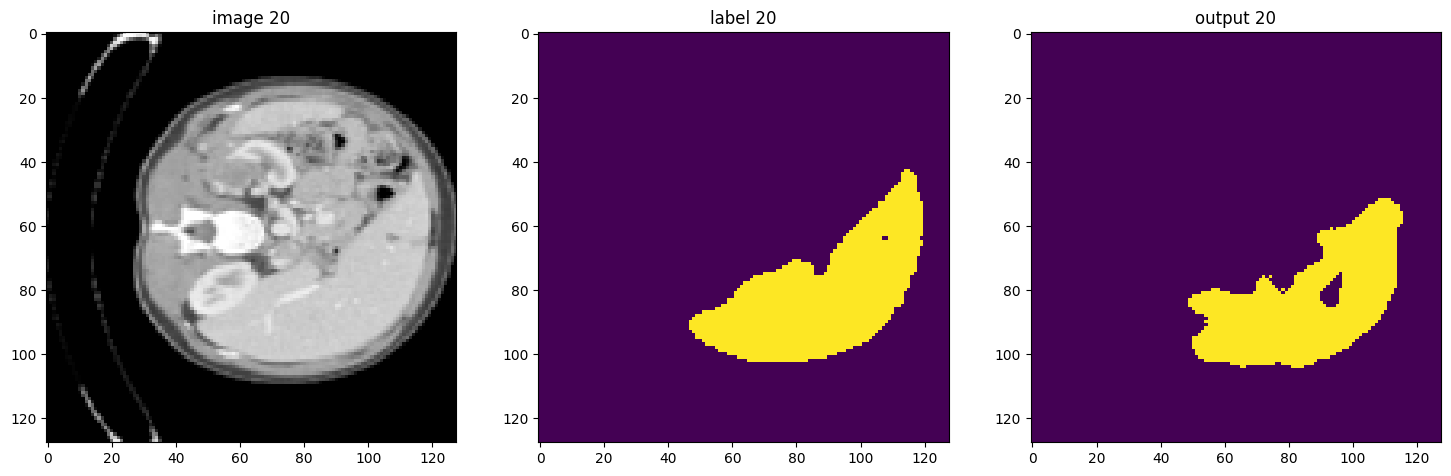

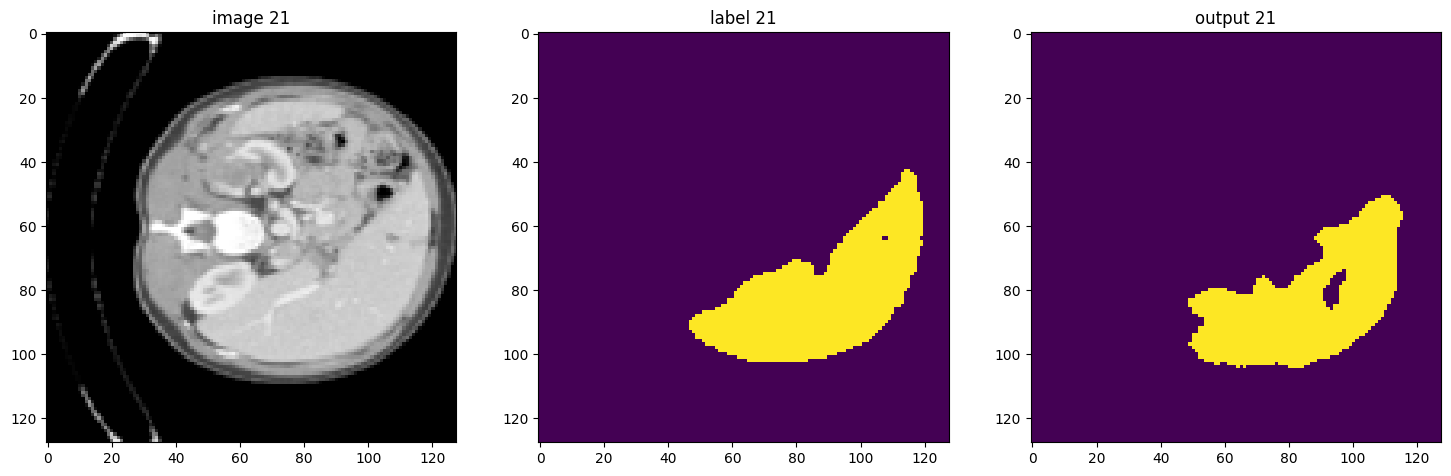

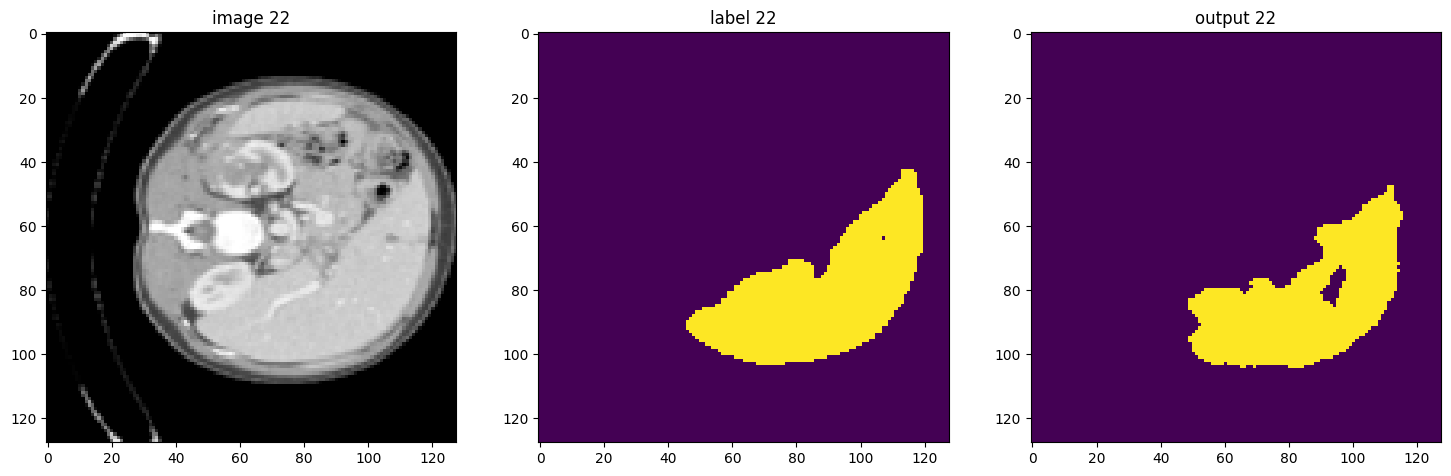

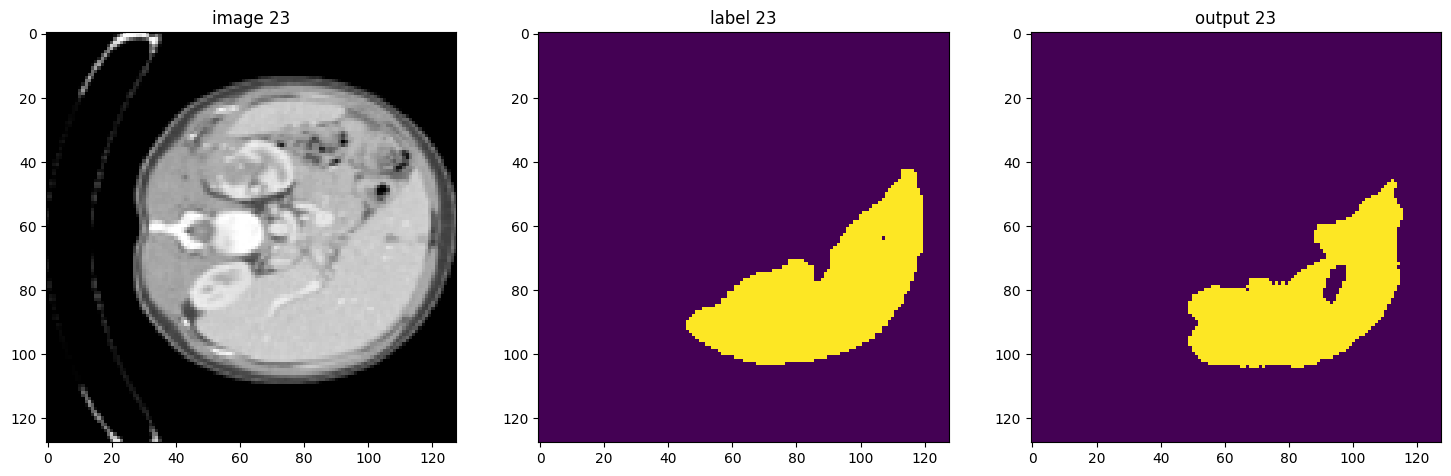

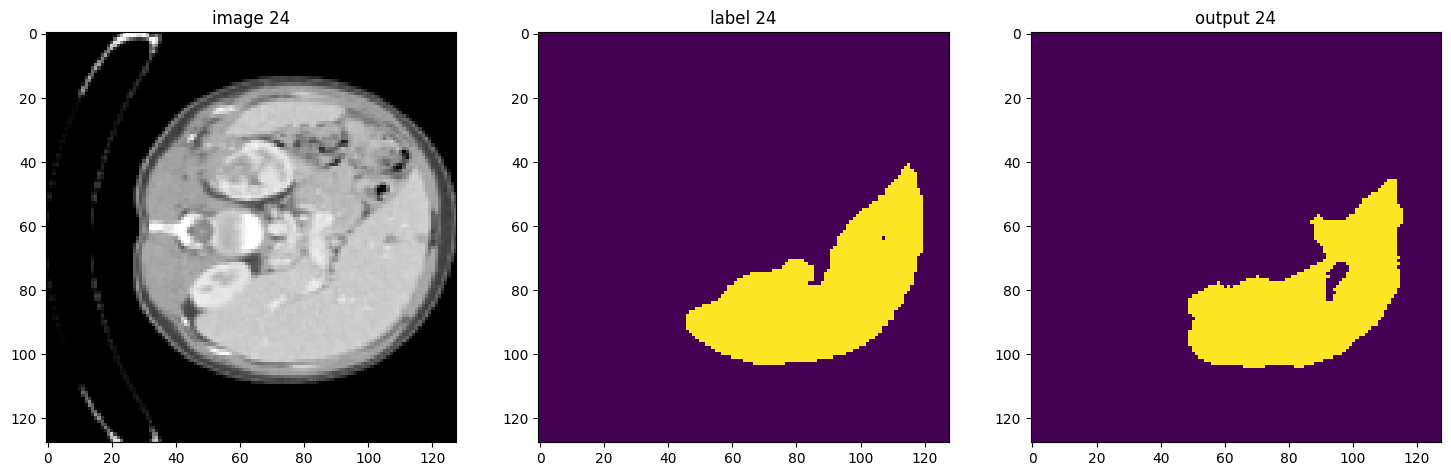

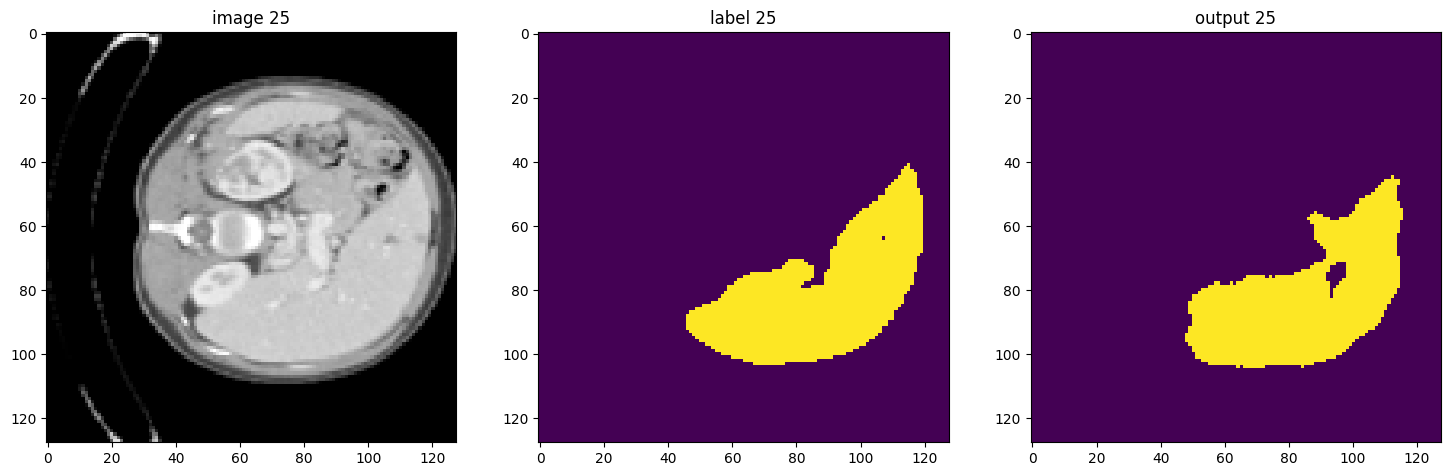

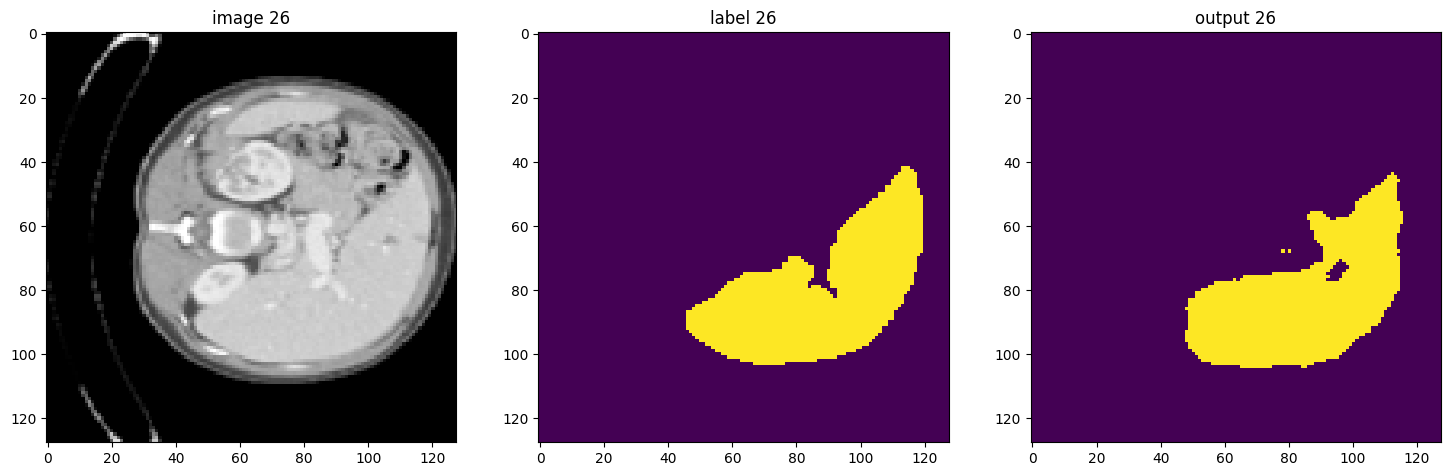

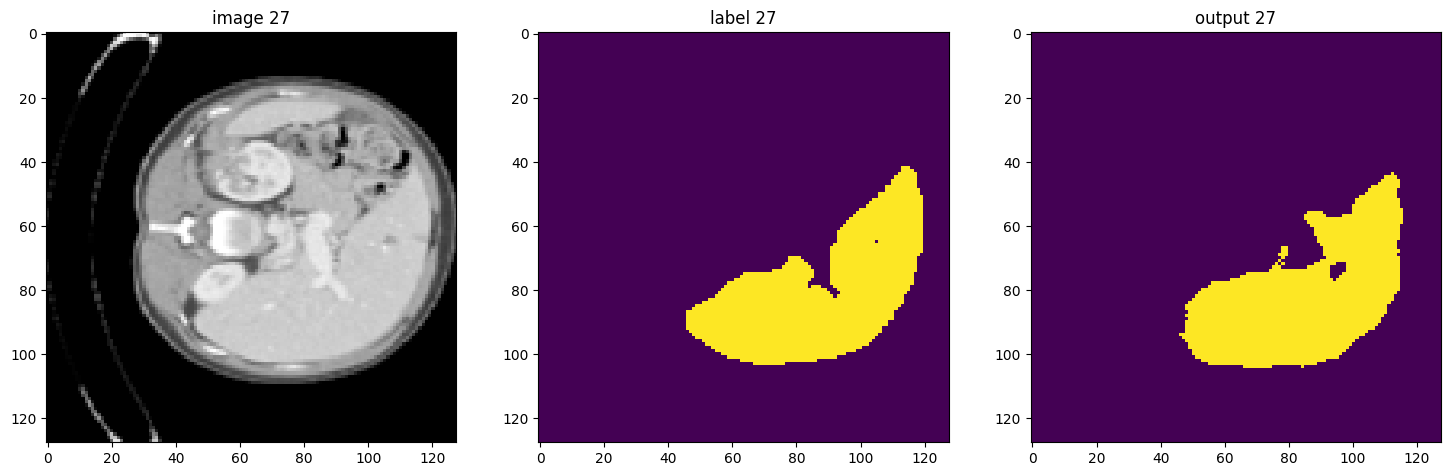

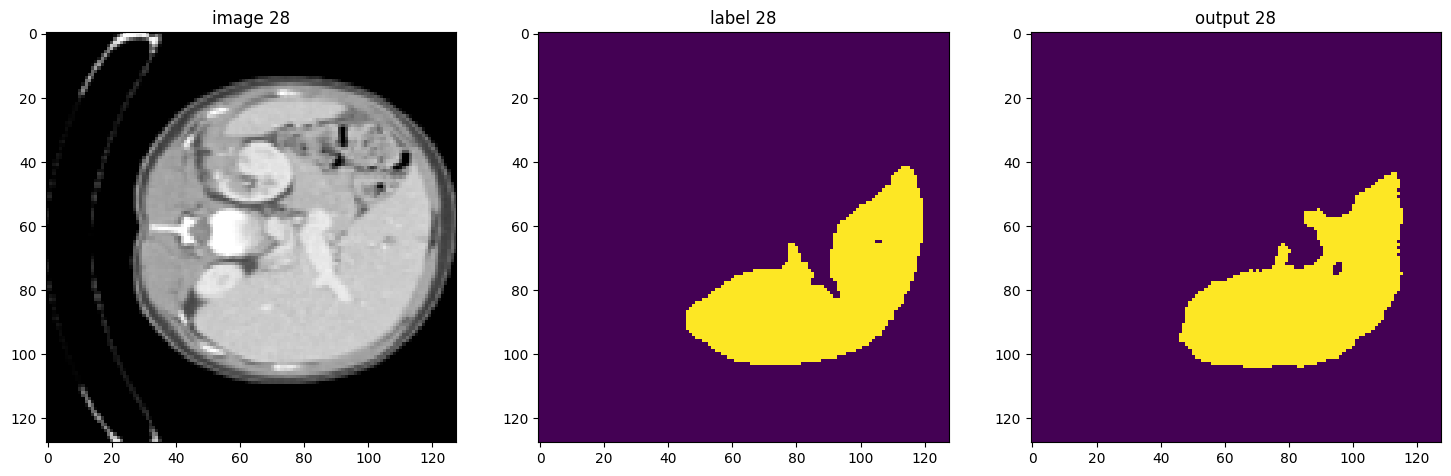

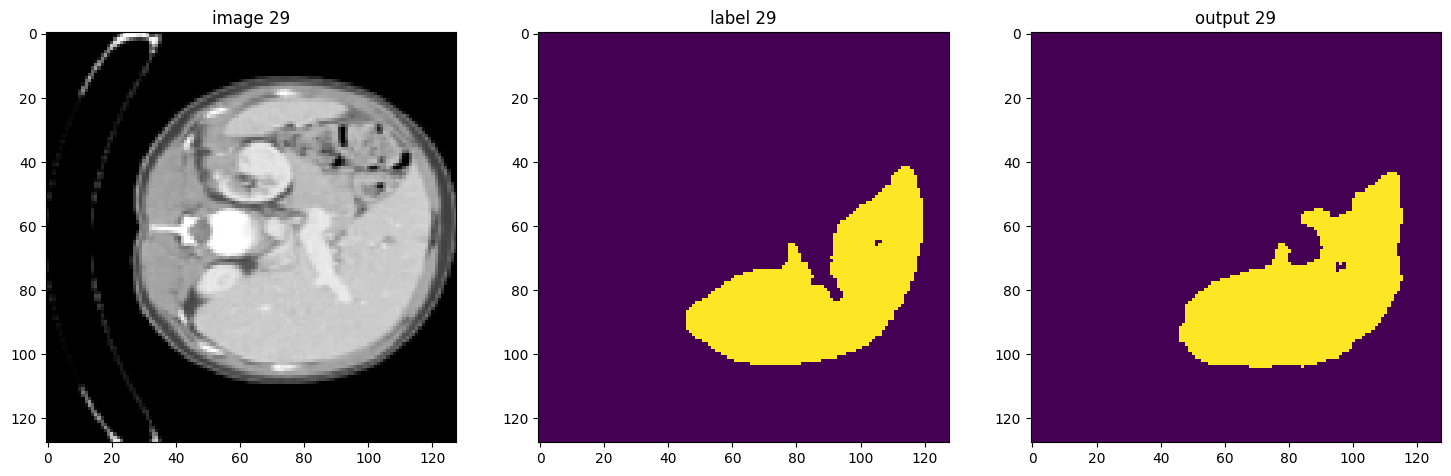

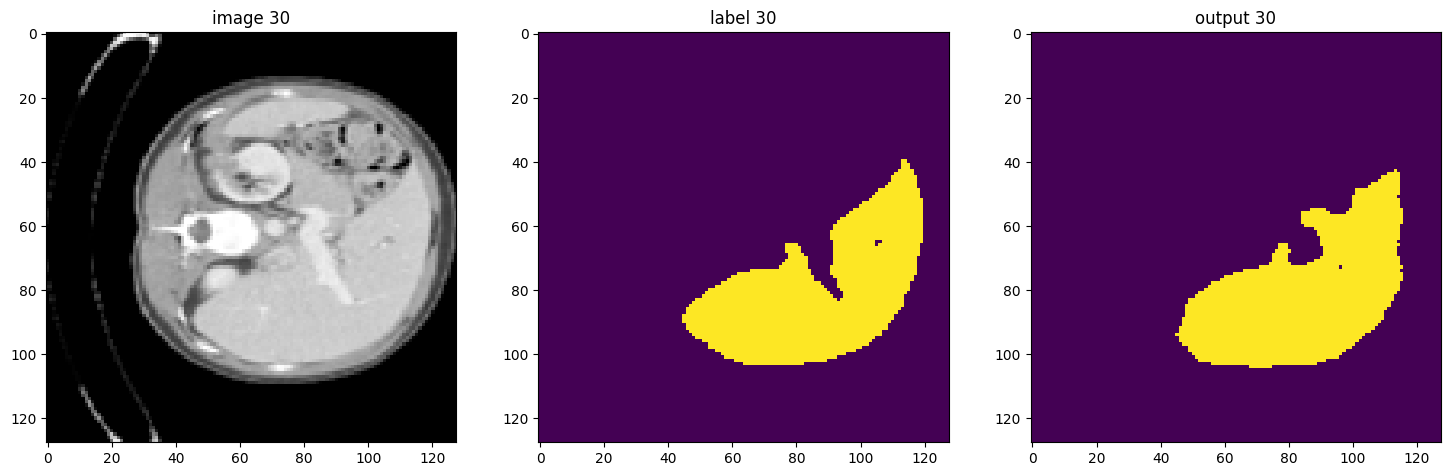

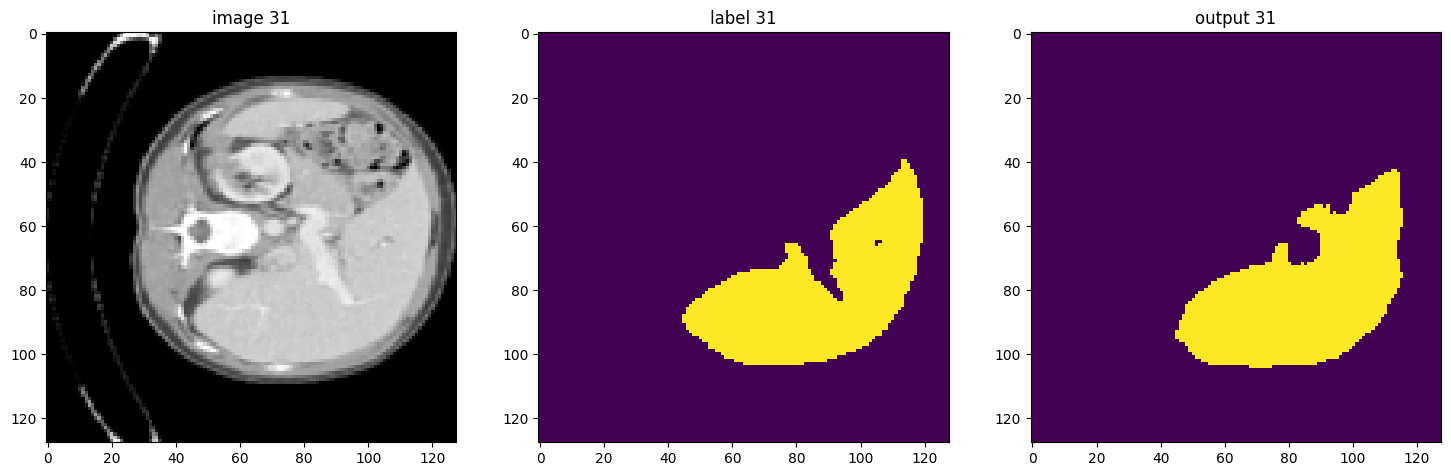

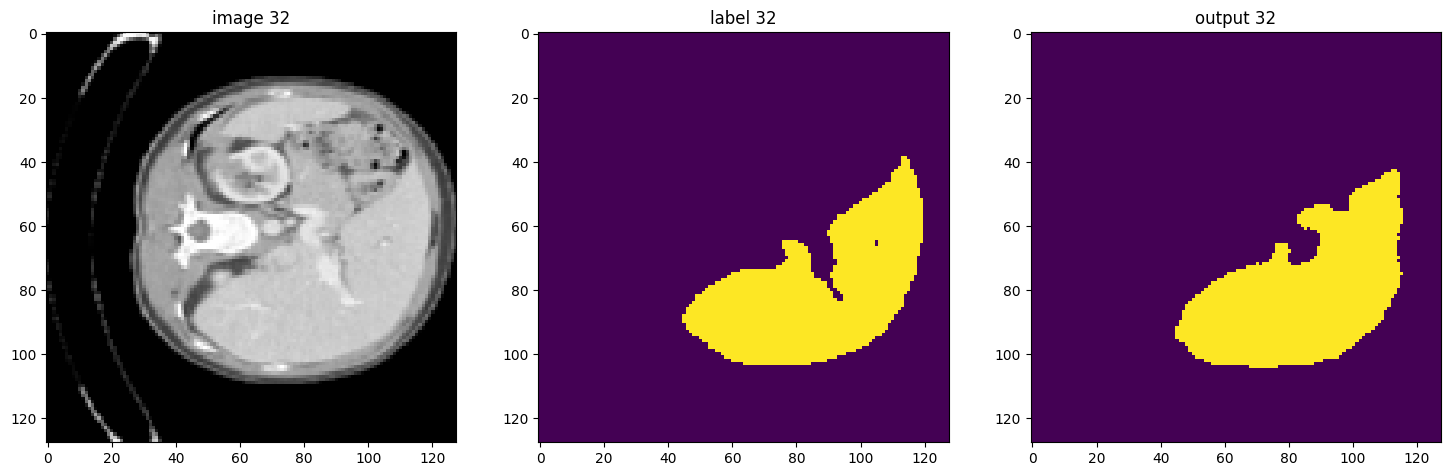

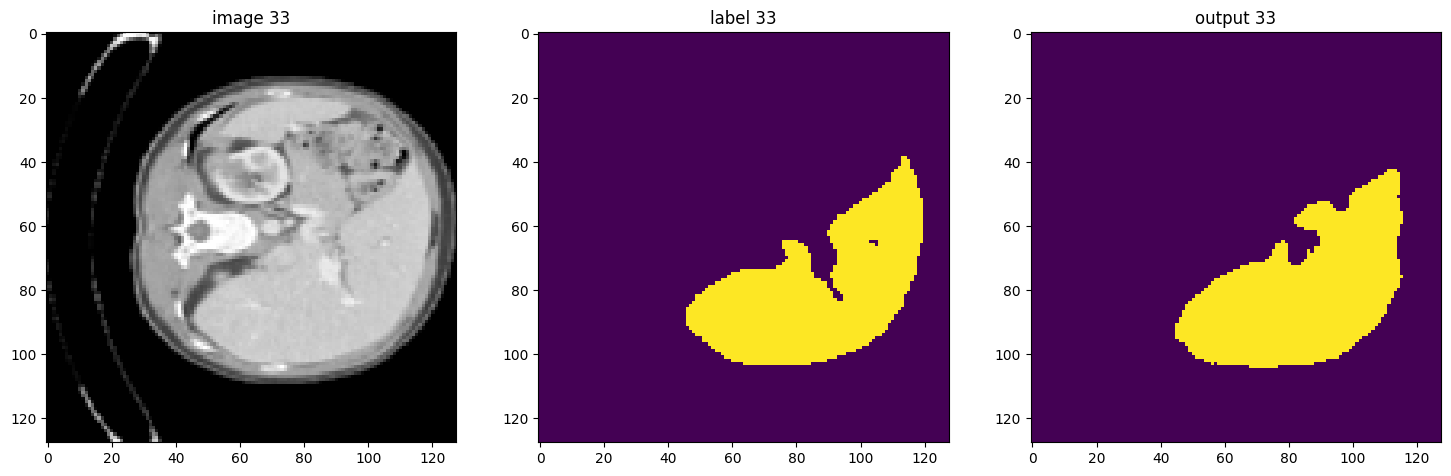

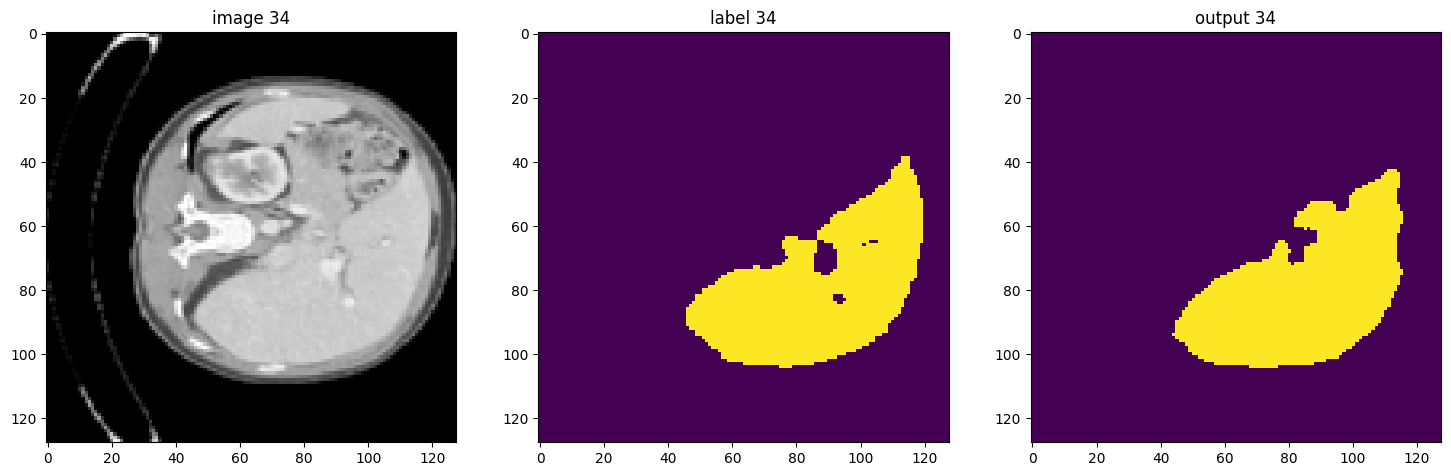

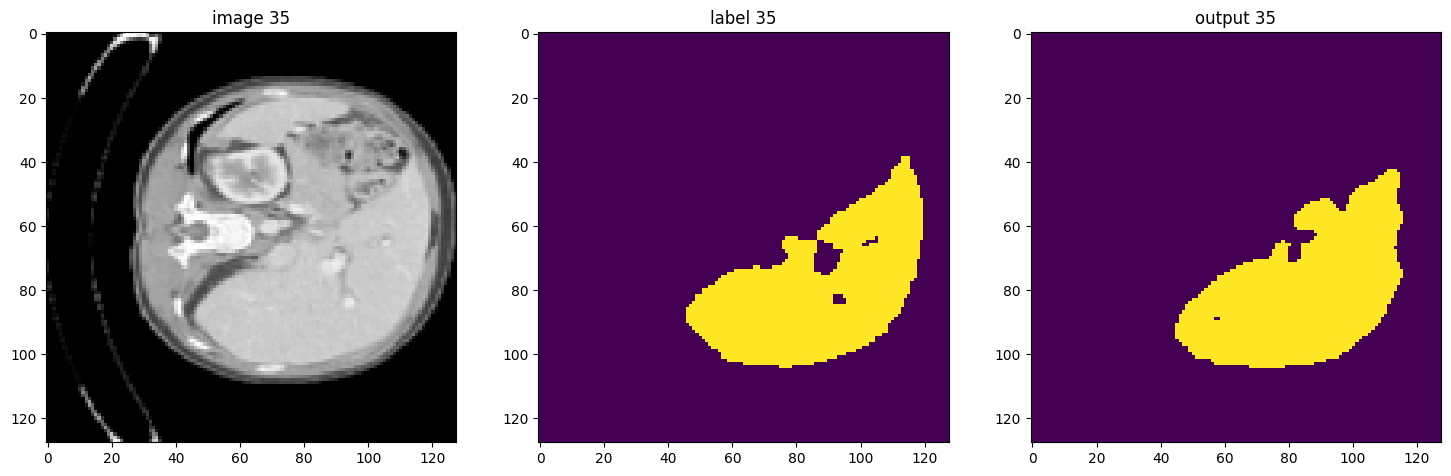

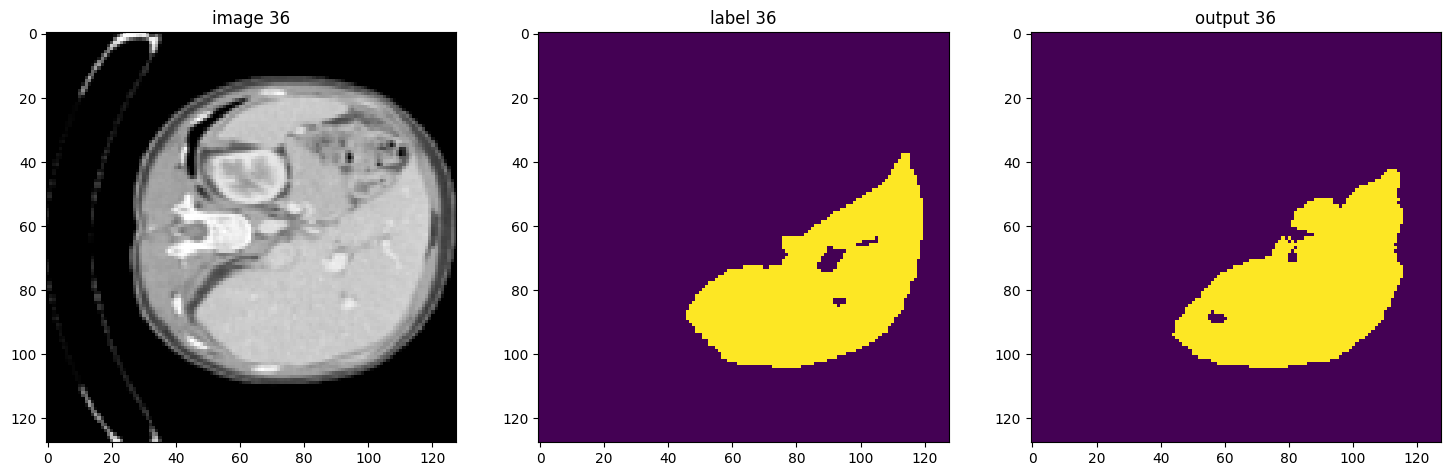

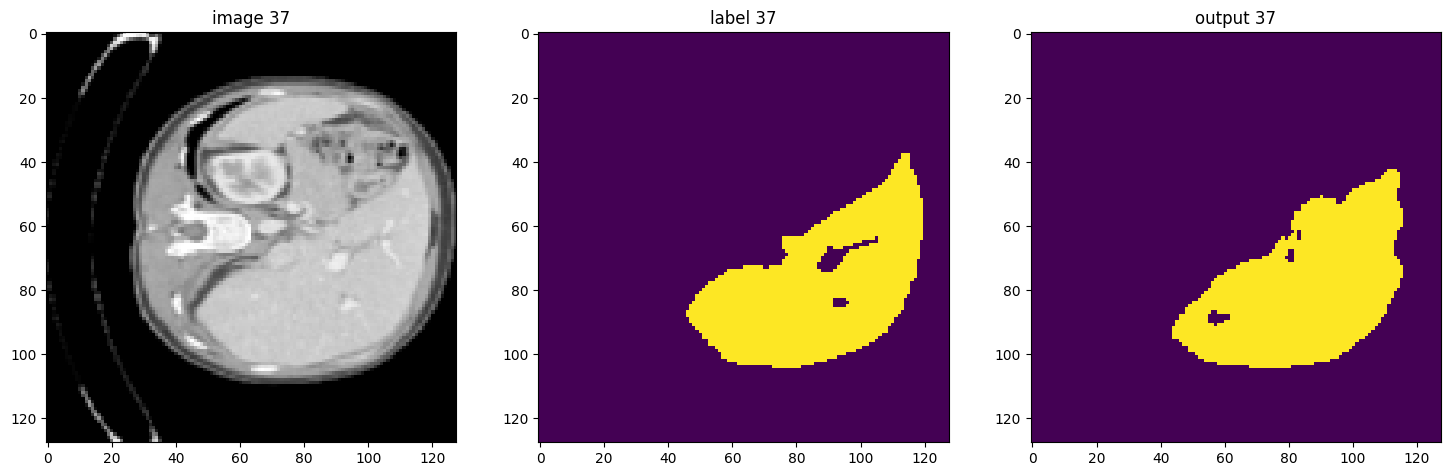

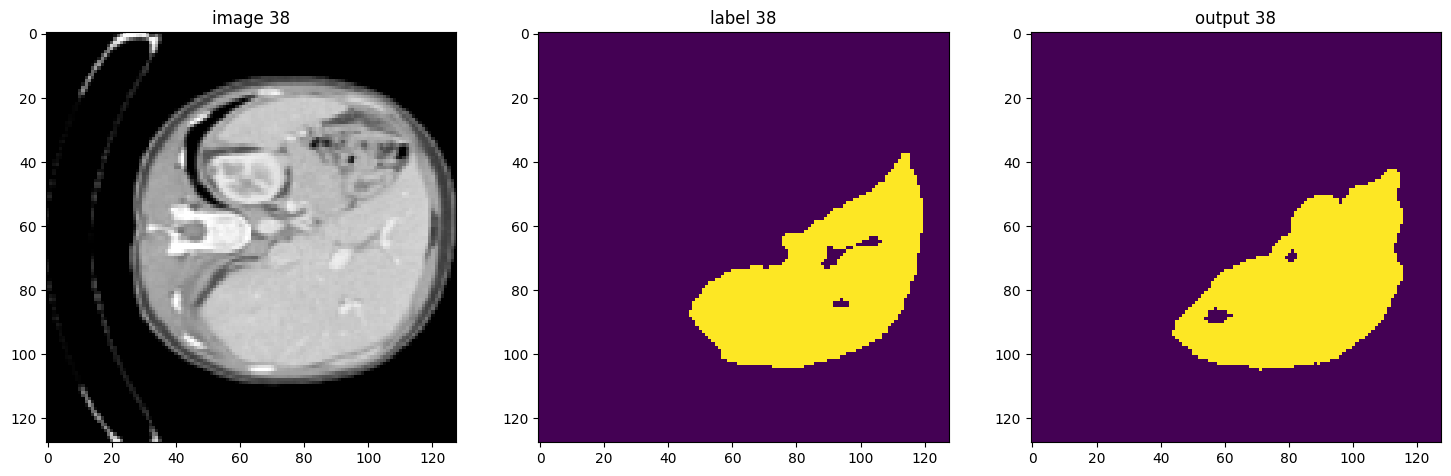

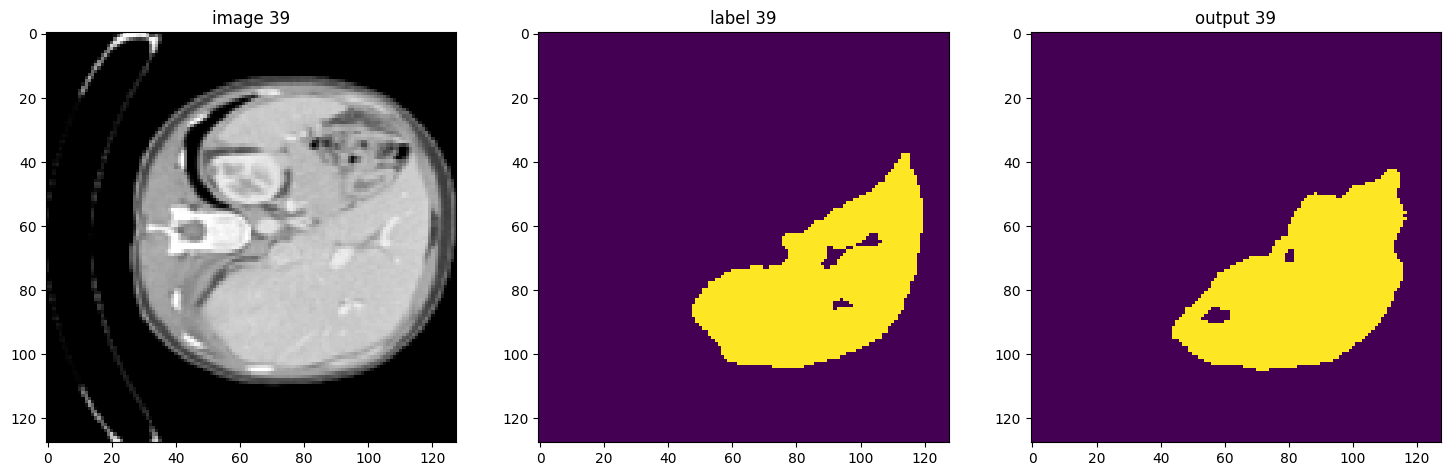

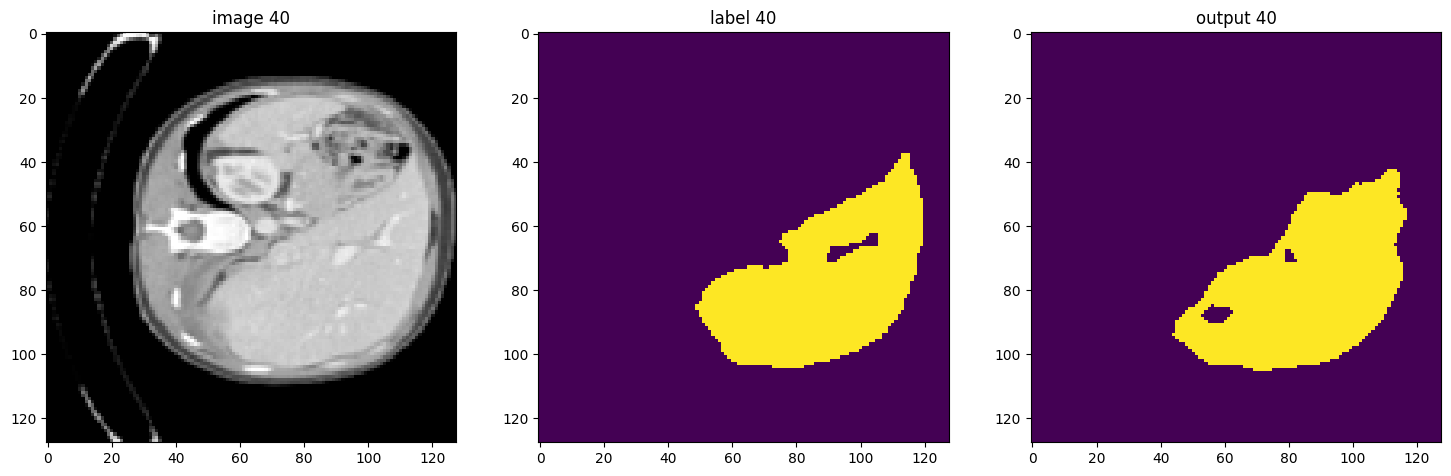

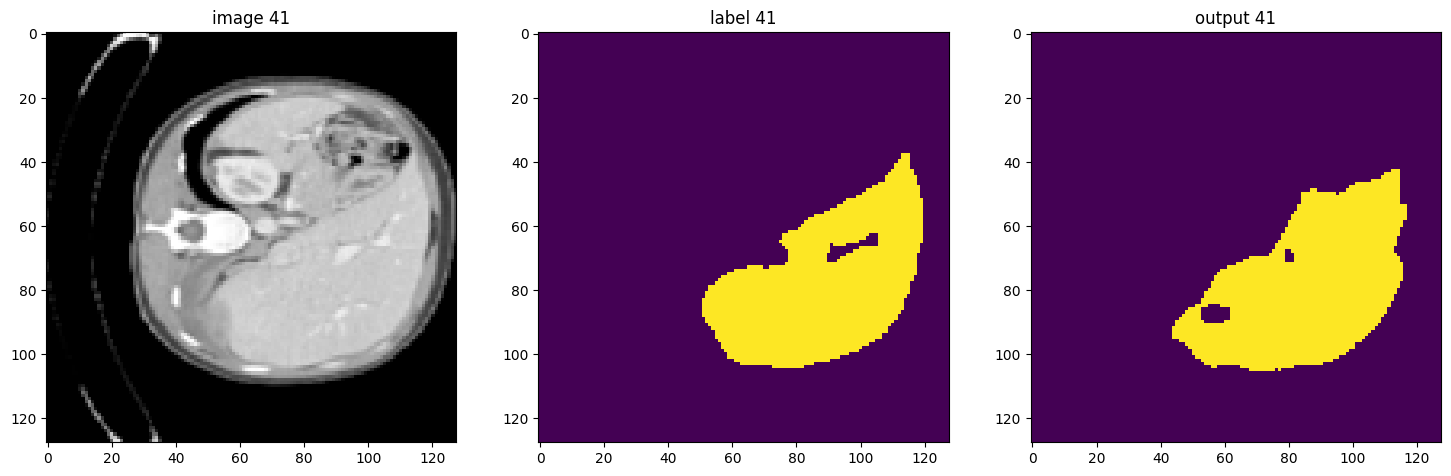

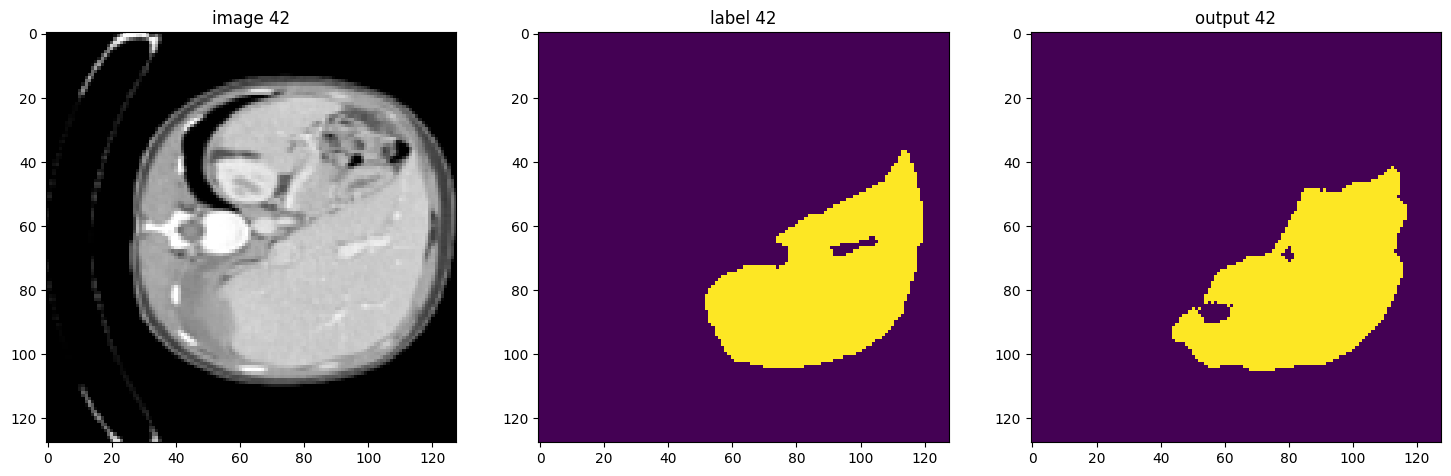

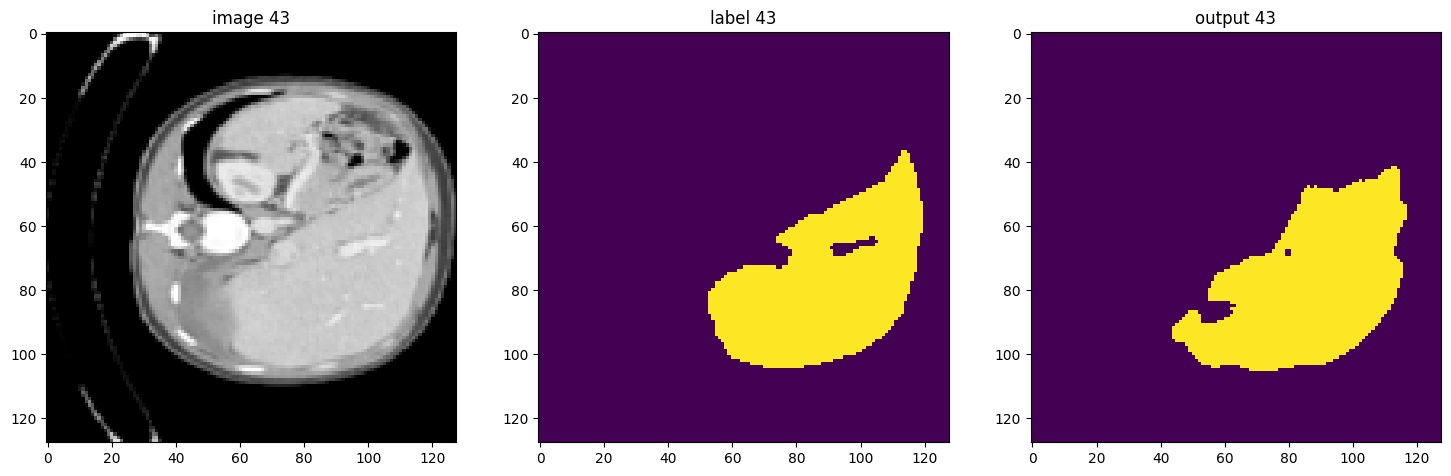

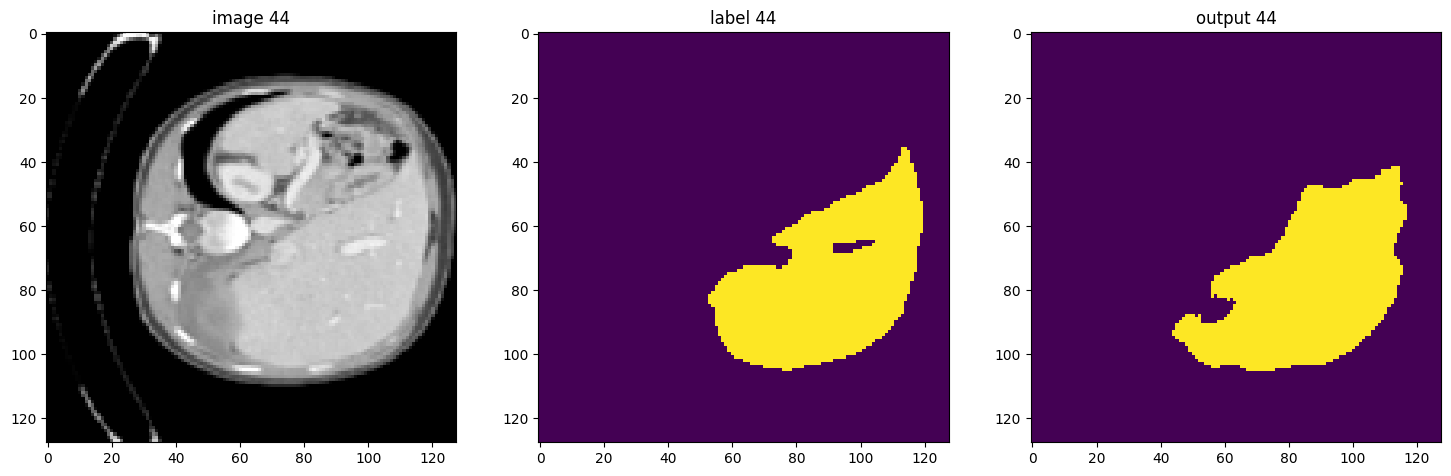

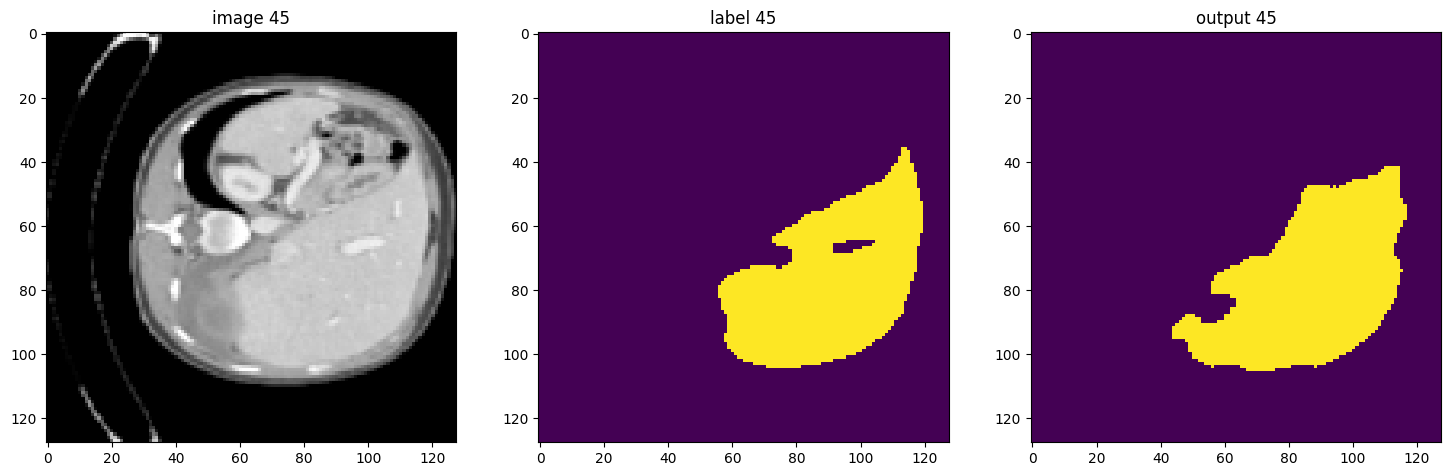

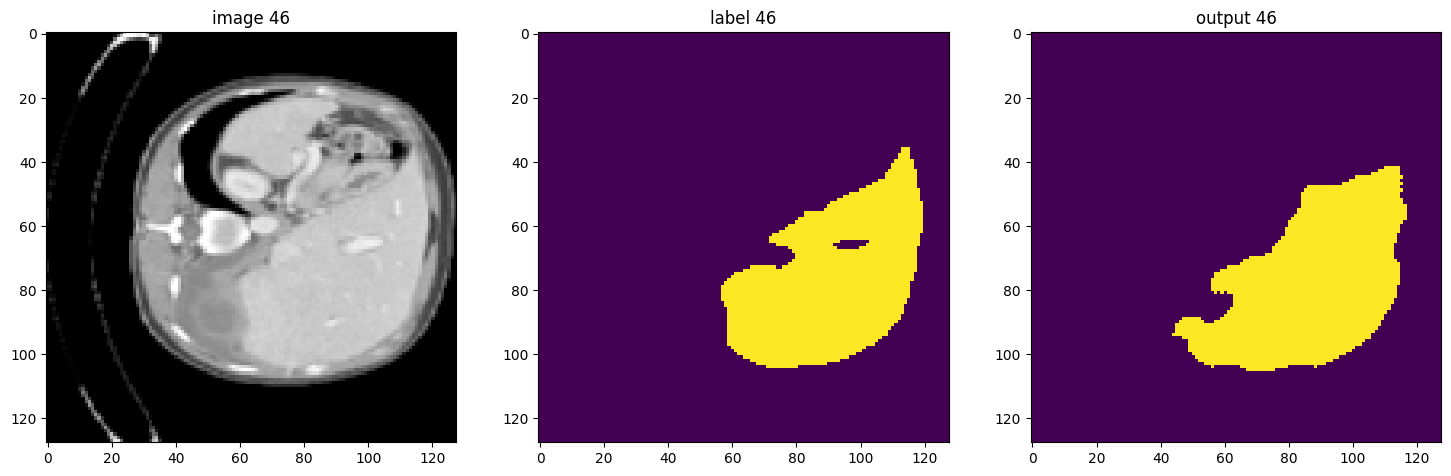

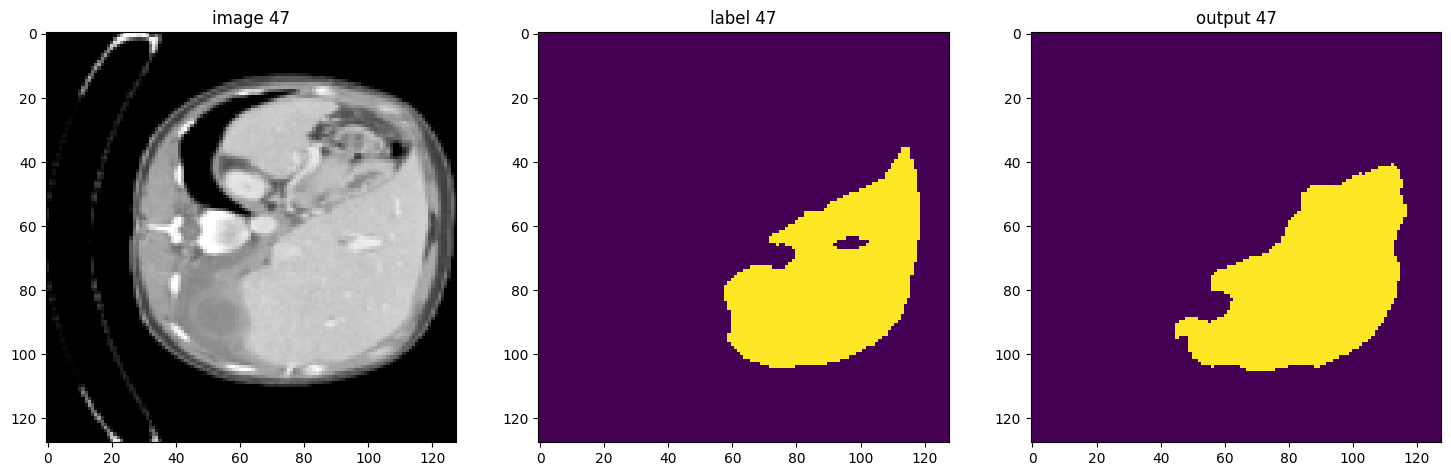

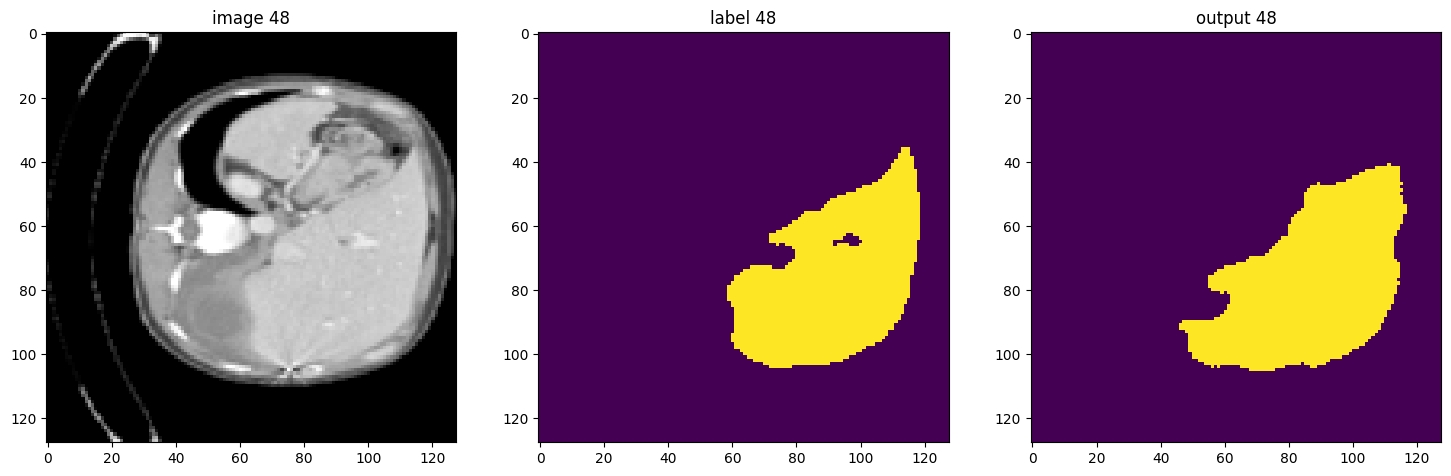

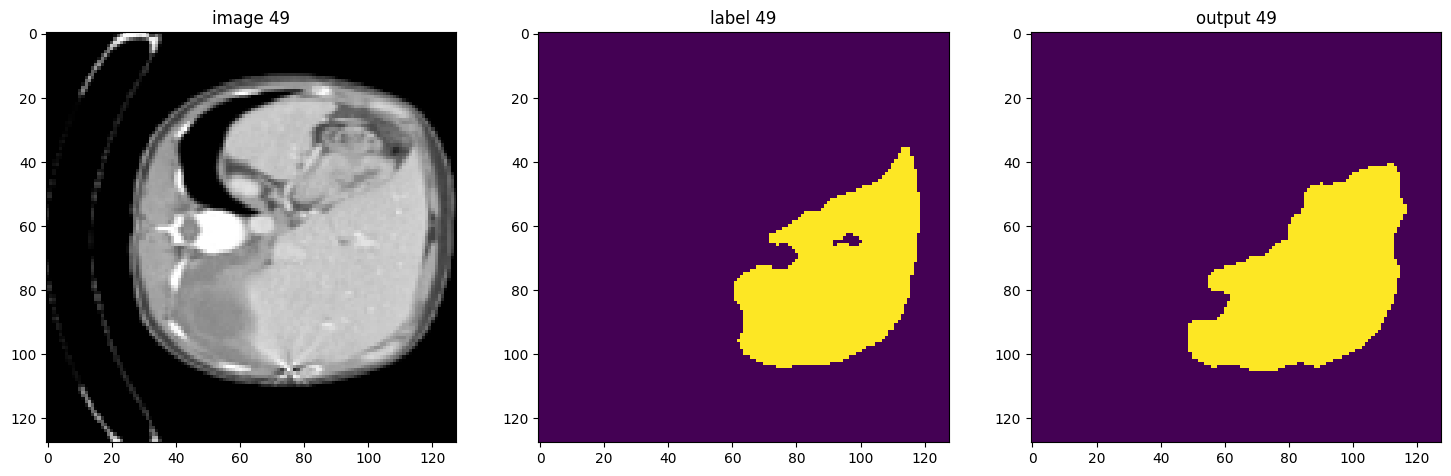

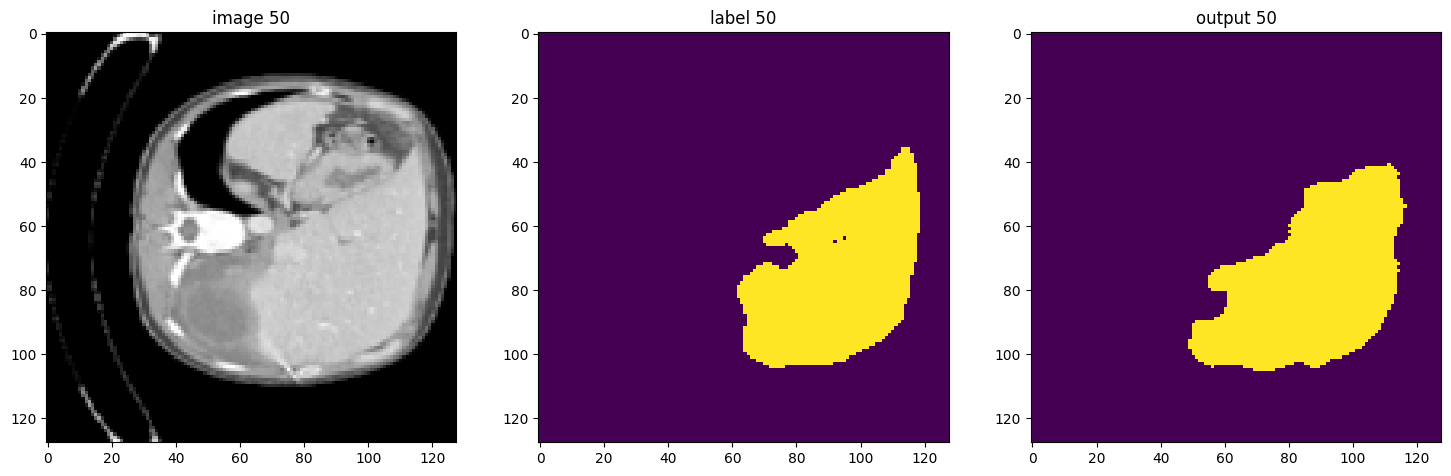

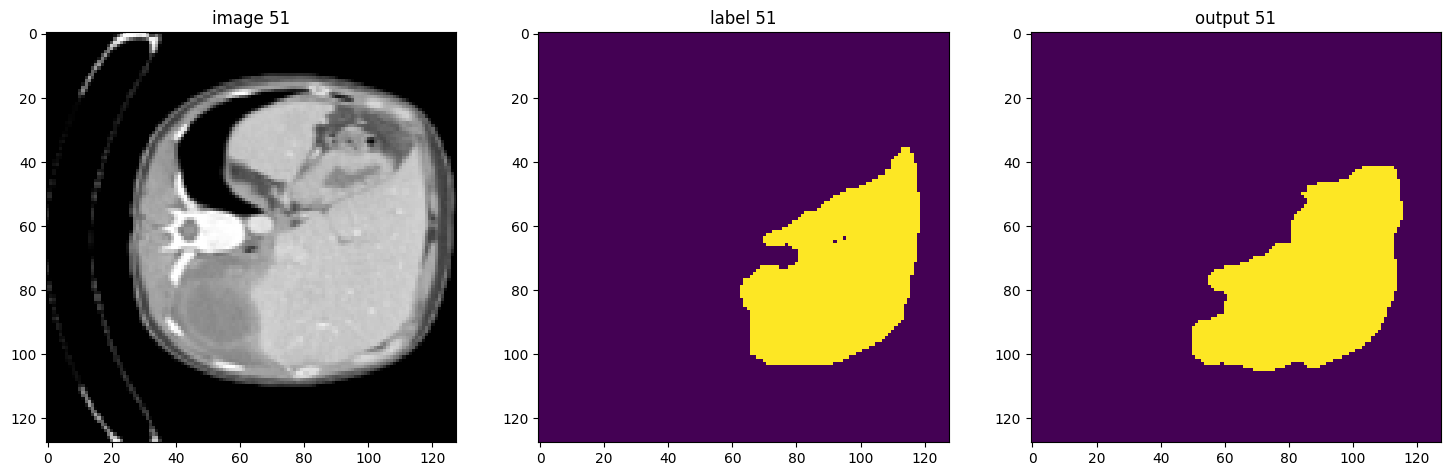

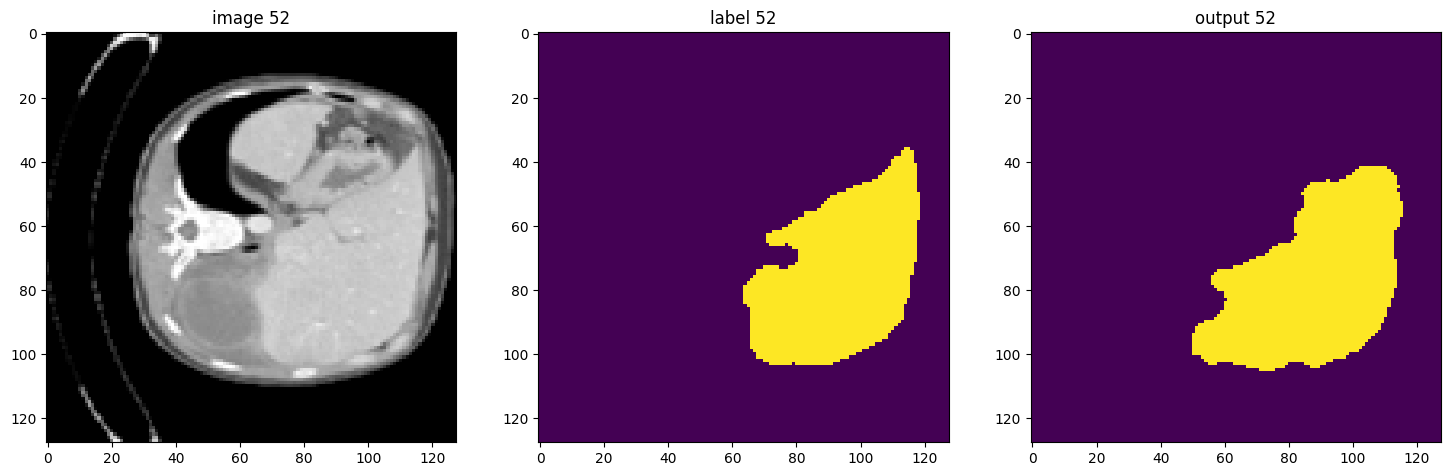

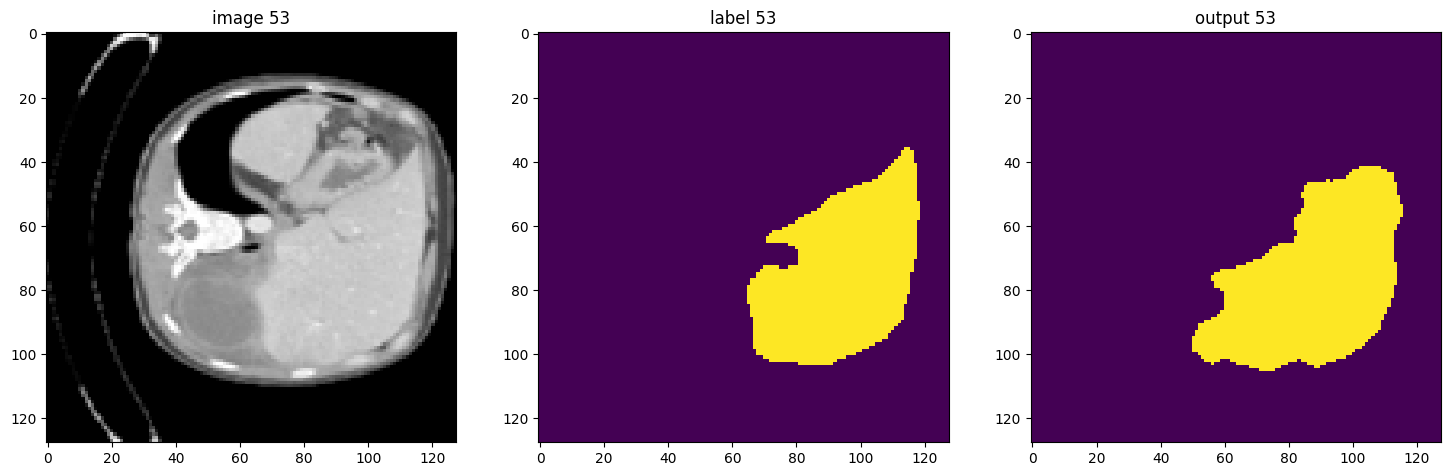

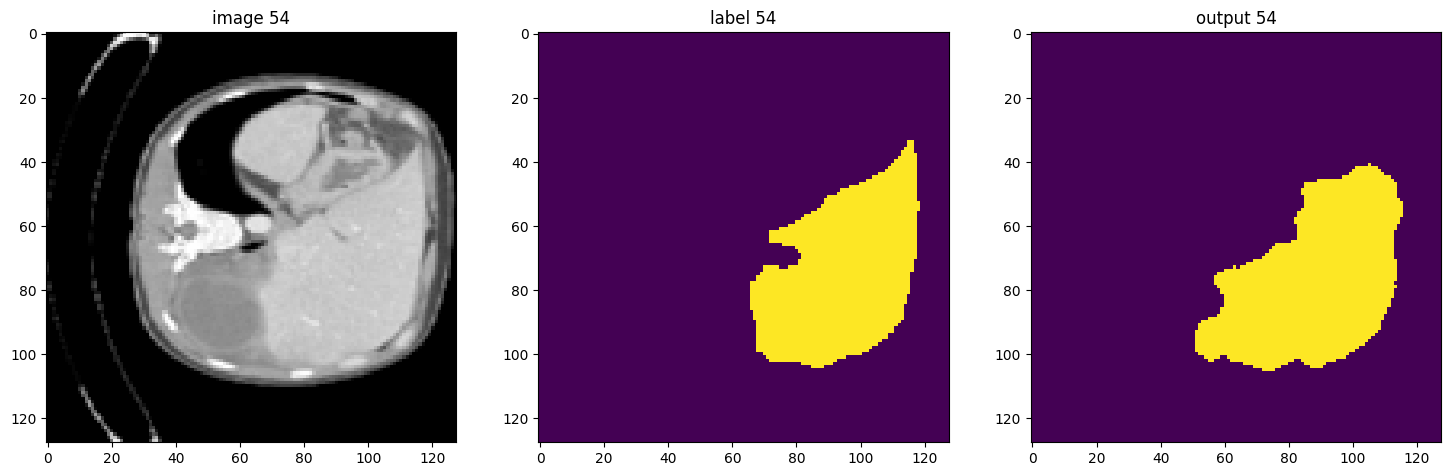

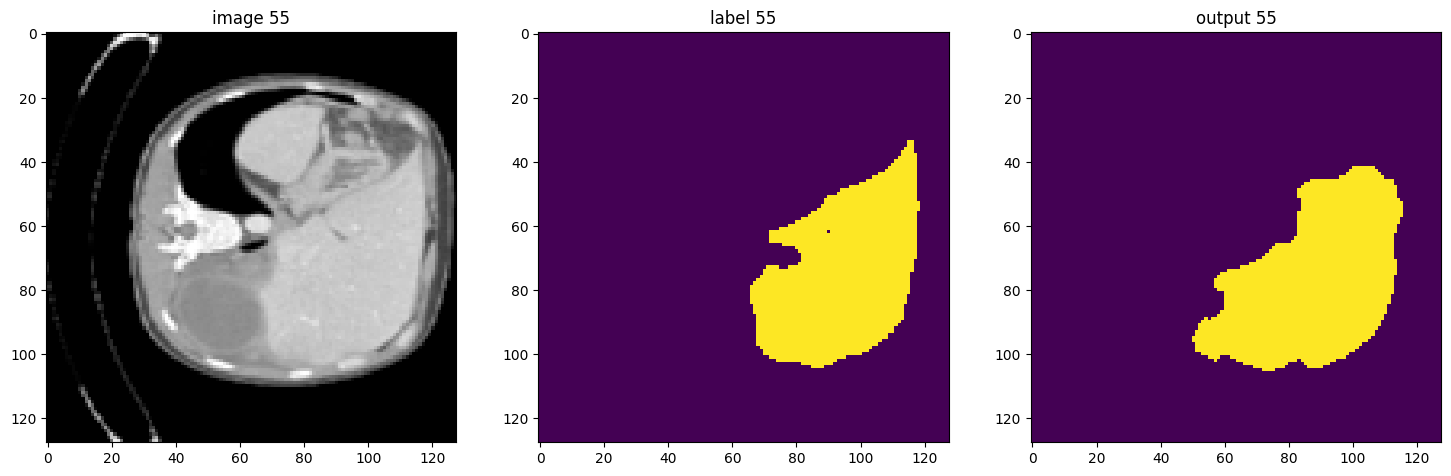

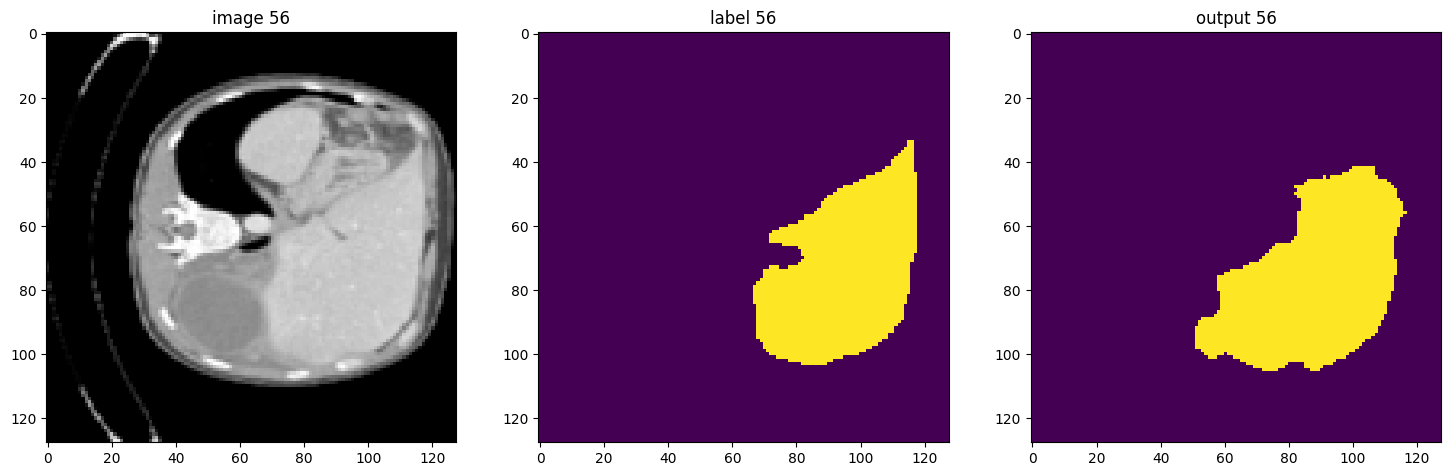

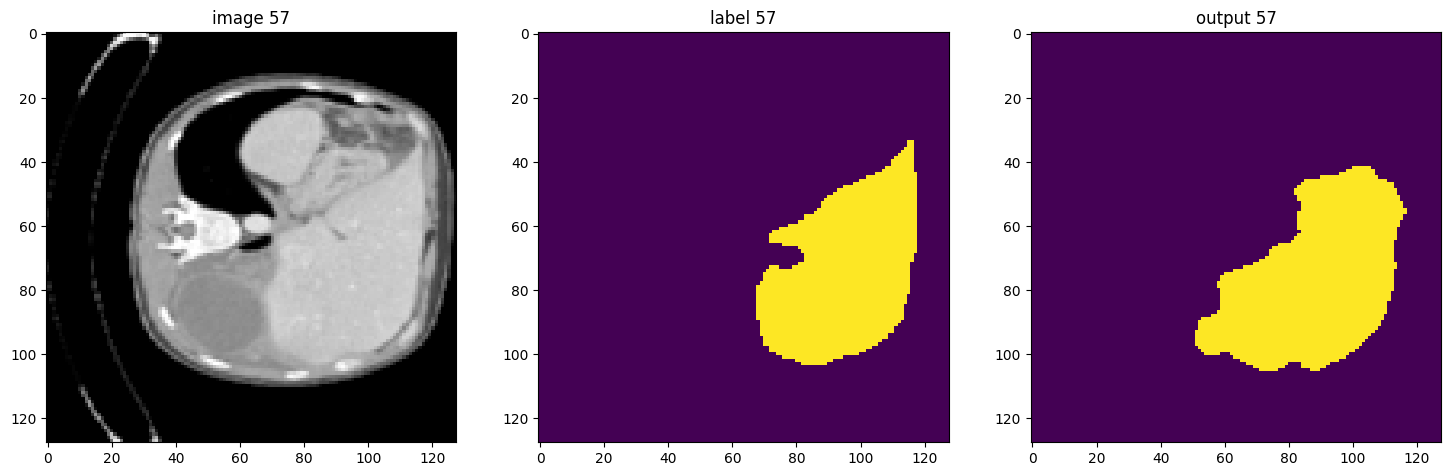

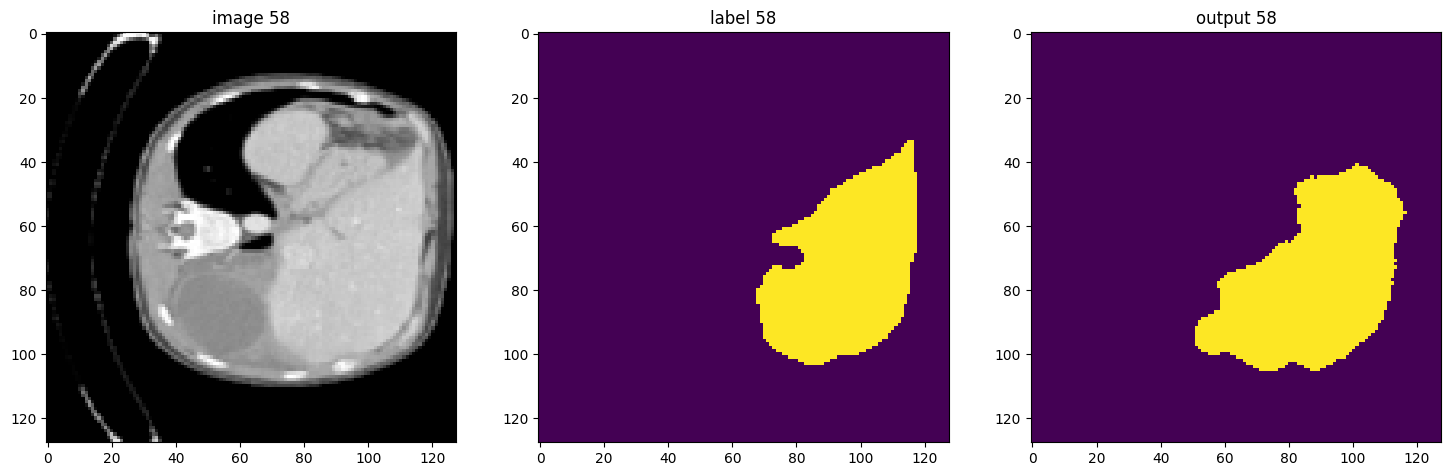

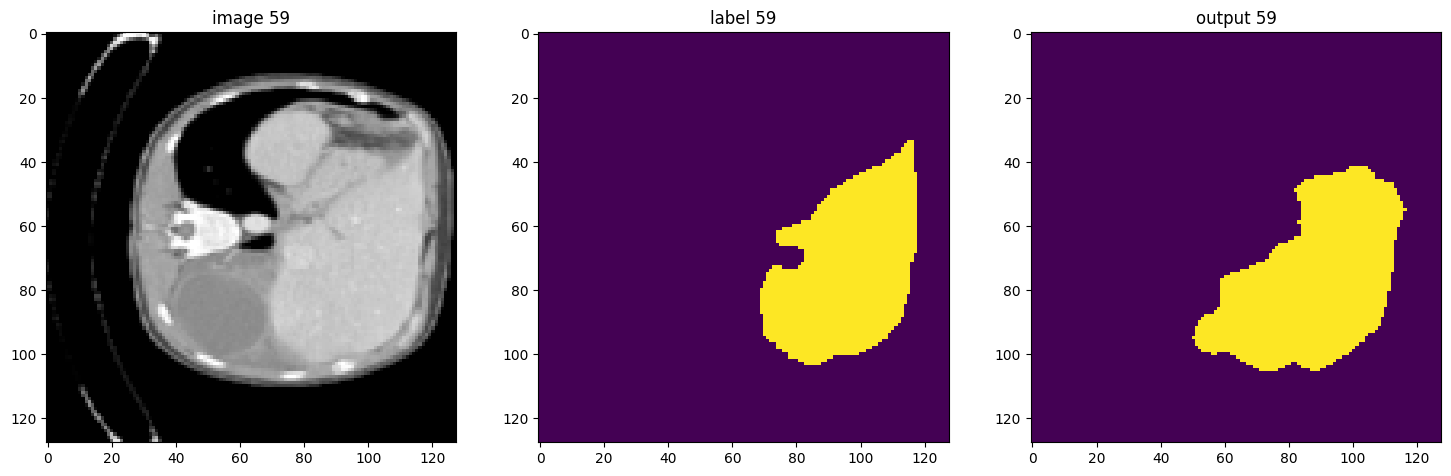

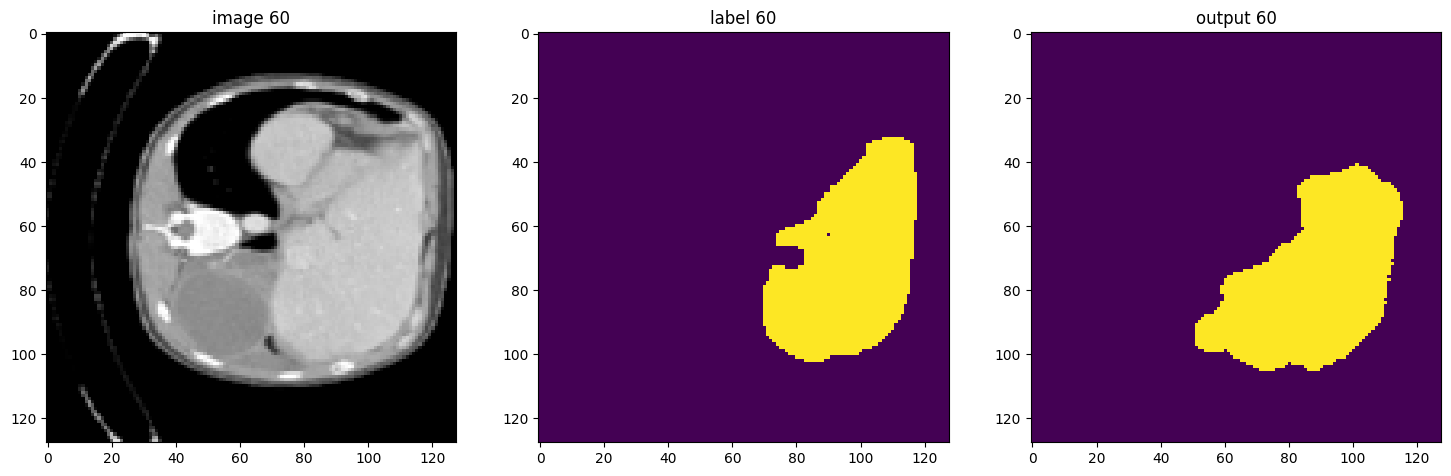

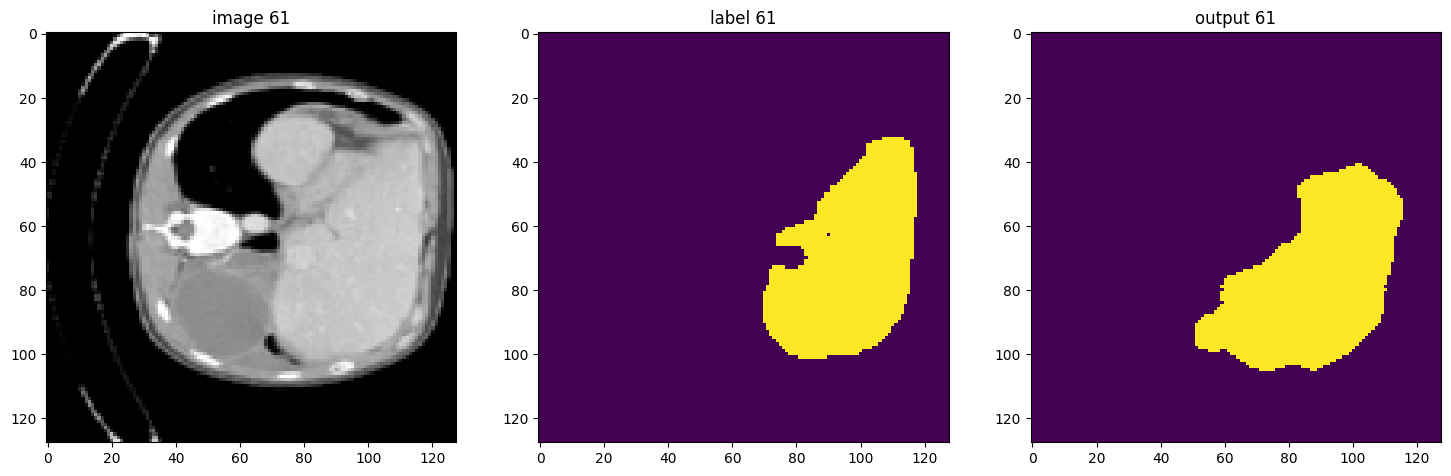

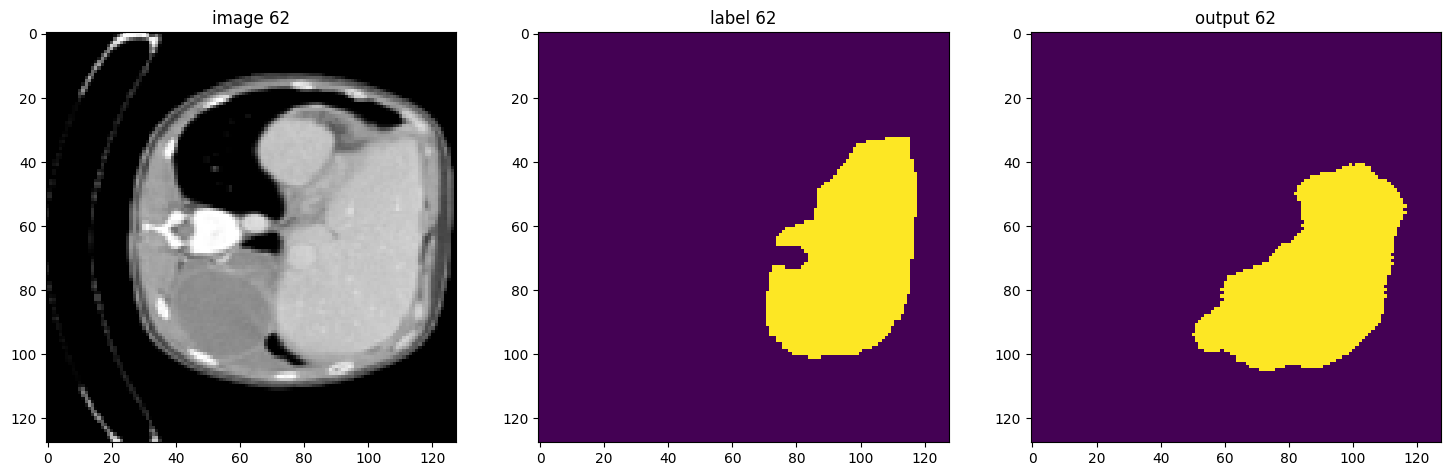

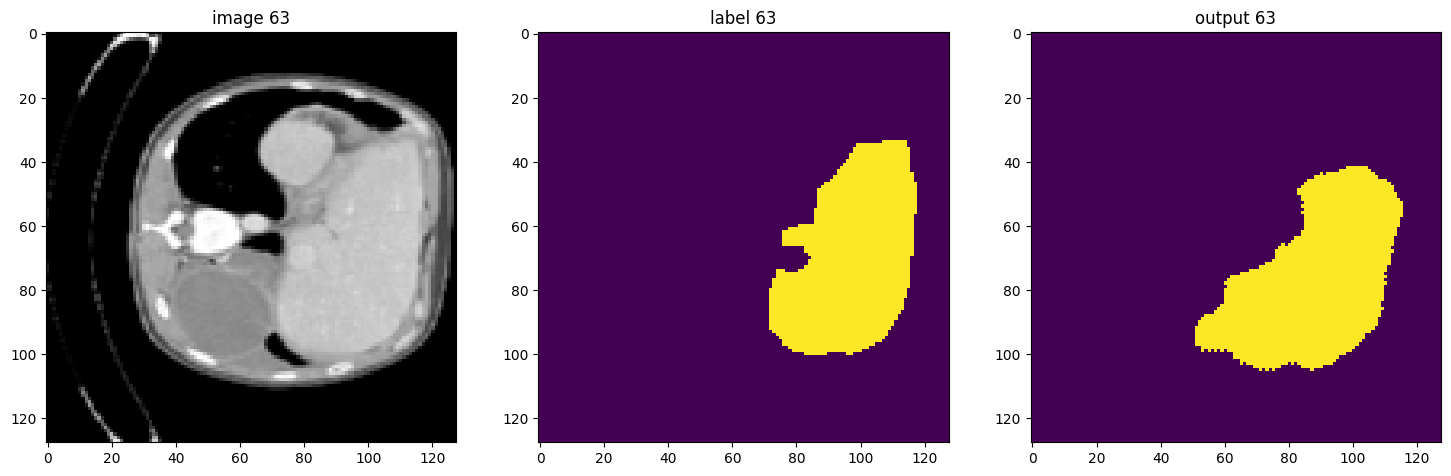

In [16]:
from monai.inferers import sliding_window_inference
from monai.transforms import Activations
import itertools


# model.eval()
_,test_loader=data_in

sw_batch_size = 4
roi_size = (128, 128, 64)
with torch.no_grad():
    # test_patient = first(test_loader)
    test_patient= next(itertools.islice(test_loader, 1, 2))
    t_volume = test_patient['imag']
    #t_segmentation = test_patient['seg']

    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.65 #0.53

    for i in range(64):
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["imag"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["lab"][0, 0, :, :, i] != 0)
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i])
        plt.show()